# Projeto Aprendizagem Automática Avançada

# Trabalho laboratorial Nº 3

### Alunos: 
* A45102 Miguel Távora
* A45140 Duarte Domingues


<hr style="border:2px solid black"> </hr>

### Imports

In [3]:
import numpy as np
import numpy.random as rd
import matplotlib.pyplot as plt
import pickle
from tensorflow import keras
import tensorflow as tf
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import load_model
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.preprocessing.image import save_img
import os
import glob
from tensorflow.keras.preprocessing.image import load_img, img_to_array, ImageDataGenerator
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dropout, Dense, LeakyReLU, BatchNormalization
from tensorflow.keras.callbacks import EarlyStopping, TensorBoard
import cv2
from pathlib import Path
import shutil
from sklearn.metrics import confusion_matrix

In [4]:
#Utilização do GPU
print("Num GPUs Available: ", len(tf.config.list_physical_devices('GPU')))

Num GPUs Available:  1


## Parâmetros globais

In [5]:
#bsize
bSize=10
#tamanho para qual todas as imagens irão ser resized
ISize=(224,224)

## Funções Auxiliares

Função para obter loss e a accuracy ao longo do treino no conjunto de treino e validação

In [6]:
def get_train_history(train):
    h=train.history
    h.keys()
    plt.figure(figsize=(10,5))
    plt.plot(h['loss'], label='Loss_train')
    plt.plot(h['val_loss'], label='Loss_val')
    plt.plot(h['accuracy'], label='Accuracy_train')
    plt.plot(h['val_accuracy'], label='Accuracy_val')
    plt.legend()
    plt.grid()
    plt.show()
    

Função para dar plot na matriz de confusão

In [7]:
# -*- coding: utf-8 -*-
import numpy as np
import itertools
import matplotlib.pyplot as plt
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    fig=plt.figure(figsize=(20,20))
    plt.imshow(cm, interpolation='none', cmap=cmap)
    plt.title(title)
    plt.colorbar(fraction=0.046, pad=0.04)
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45,ha='right')
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    #return fig

<hr style="border:2px solid black"> </hr>

### Ler dados do ficheiro pickle

Inicialmente é necessário ler os dados do ficheiro pickle do Oxford-IIIT-Pet_Dics.

In [8]:
p_path="Oxford-IIIT-Pet_Dics.p"
D=pickle.load(open(p_path,'rb'))


In [9]:
classes = D['classDic']

### Criar uma lista com os nomes de todas as classes

De seguida é necessário criar uma lista com os nomes de todas as classes.

In [11]:
def getList(dic):
    list = []
    for key in dic.keys():
        list.append(key)
          
    return list

In [12]:
classesNames= getList(classes)

### Obter o dicionário de chave valor que contém informação de todas as imagens no dataset

In [17]:
files = D['filesDic']

In [20]:
print(files['Abyssinian_1.jpg'])

{'species': 'cat', 'breed': 'Abyssinian', 'target': 25, 'imgDim': (400, 600, 3), 'bndBox': [333, 72, 92, 86], 'foldTrain': True}


Cada imagem "chave" no dicionário tem os seguintes atributos:
* species: gato ou cão (irá ser utilizado para classificação binária)
* breed: nome da classe do animal
* target: classe Multi-classe do animal (irá ser utilizado para classificação multi-classe)
* imDim: dimensões da imagem e o channel
* bndBox: bounding box com as coordenadas da cara do animal (irá ser testado a utilização da bounding box nos dados)
* foldTrain : Se a imagem irá ser utilizada para treino ou teste

In [11]:
key_list = list(files.keys())
val_list = list(files.values())

<hr style="border:2px solid black"> </hr>

## Ler as imagens do ficheiro

De seguida é necessário ler as imagens do ficheiro onde estas se encontram guardadas.

In [23]:
PATH_IMGS = "images/images" #Path onde as imagens estão guardadas

In [25]:
imageNames = [os.path.basename(file) for file in glob.glob(os.path.join(PATH_IMGS, '*.jpg'))]

print(f"\nNúmero total de imagens: {len(imageNames)}")


Número total de imagens: 7390


In [28]:
images=[]
for imgName in imageNames:
    img = plt.imread(os.path.join(PATH_IMGS, imgName))
    images.append(img)
    

As imagens são lidas a partir da função imread do Matplotlib e são adicionadas a uma lista.

<hr style="border:2px solid black"> </hr>

## Verificar se há Imagens com dimensões diferentes de 3

Um cuidado que foi necessário ter foi assegurar que todas as imagens têm a mesma dimensões do channel. Foi então criada a seguinte função para verificar o número de imagens com channel com dimensões diferentes de 3.


In [35]:
def checkImagesDimensions(images):

    dim2=0
    dim4=0
    
    for img in  (images):
        #check images with 2 dimensions
        if len(img.shape) ==2:
            dim2=dim2+1
            plt.figure()
            plt.imshow(img)
            
        #check imagens with 4 dimensions
        if len(img.shape)>2:
            if img.shape[2] ==4:
                dim4=dim4+1
                plt.figure()
                plt.imshow(img)
    
    print ("Imagens com dimensões diferentes de três: ", dim2+dim4)
    print("Numero de imagens com apenas duas dimensões: ",dim2)
    print("Número de imagens com quatro dimensões: ",dim4)

Imagens com dimensões diferentes de três:  12
Numero de imagens com apenas duas dimensões:  3
Número de imagens com quatro dimensões:  9


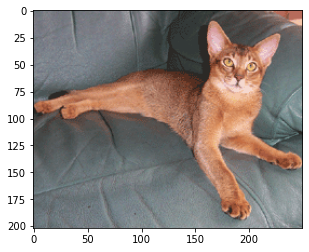

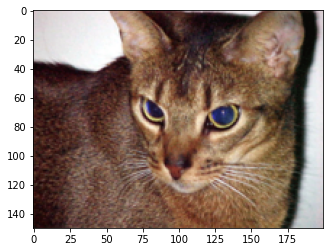

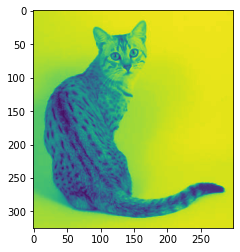

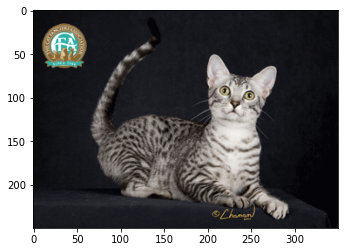

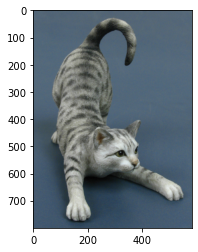

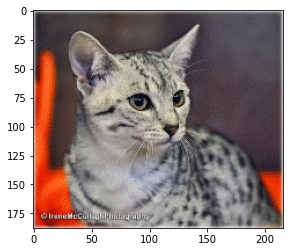

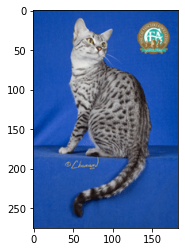

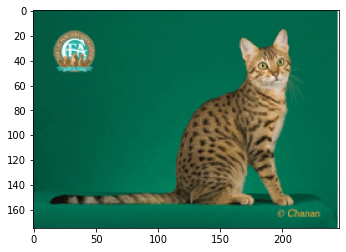

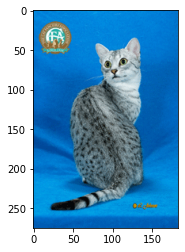

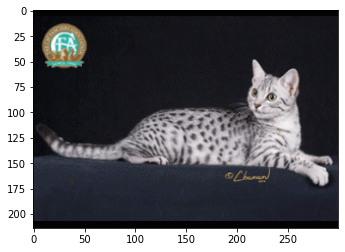

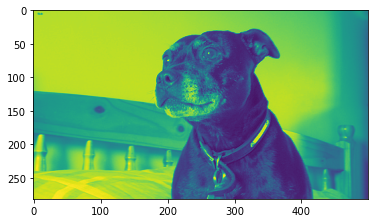

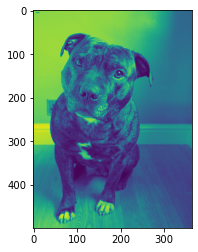

In [36]:
checkImagesDimensions(images)

Verificou-se que existem:
* 3 imagens com apenas 2 dimensões
* 9 imagens com 4 dimensões

Vai ser necessário então converter todas as imagens para RGB, de forma a manter consistência entre todas as imagens.

<hr style="border:2px solid black"> </hr>

# Pre-processamento das imagens

Em relação ao processo de pre-processamento das imagens, as imagens vão ser processadas de três diferentes formas:

* Imagens resized para um tamanho especifico com a adição de padding.
* Imagens resized para um tamanho especifico sem a adição de padding.
* Imagens resized para um tamanho especifico com padding com a adição de bounding boxes nas imagens de treino.

## Aplicar Bounding Box às imagens de treino

De seguida vai ser realizada a adição de bounding boxes às imagens de treino, e o resize de todas as imagens com padding.

Como apenas as imagens de treino têm padding, é de esperar que esta adição não seja muito benéfica, devido à discrepância entre os dados do conjunto de treino e teste.


### Transformar as imagens para terem apenas a àrea da bounding box

A seguinte função, transform_images_bbox permite retornar um conjunto de treino com as imagens resized, aplicando as bounding boxes às imagens de treino, o funcionamento é o seguinte:
* Para ambas as imagens de treino e teste é verificado se cada imagem tem 3 channels, e caso não tenha é realizada a conversão da imagem para 3 channels utilizando o cv2.cvtColor.
* Caso a imagem faça parte do conjunto de treino é aplicada a bounding box à imagem, ficando apenas com área da imagem que pertence à bounding box.
* Apôs isto as imagens são todas resized para um tamanho especifico, realizando um resize com padding de forma a não adicionar distorção às imagens.
* Todas as imagens são guardadas num numpy array de forma a serem utilizadas no processo de classificação.

In [33]:
def transform_images_bbox(images, imageNames,files):
    
    imagesBbx=[]
    
    for i in range(len(imageNames)):
        img = images[i]
        #verificar se a imagem é de treino
        if (files[imageNames[i]]["foldTrain"]):
            bbx = files[imageNames[i]]["bndBox"]
            #aplicar a bounding box à imagem
            imgBbx = img[bbx[1]:bbx[1]+bbx[3]+1,bbx[0]:bbx[0]+bbx[2]+1]
            
            #converter a imagem de gray para RGB
            if len(imgBbx.shape) ==2:
        
                imgBbx = cv2.cvtColor(imgBbx, cv2.COLOR_GRAY2RGB)
                
            imgResized = tf.image.resize_with_pad(img_to_array(imgBbx, 
                dtype = 'uint8'), ISize[0],ISize[1] ).numpy().astype('uint8')
            imagesBbx.append(imgResized)
        else:
            
            #converter a imagem de gray para RGB
            if len(img.shape) ==2: 
                
                img = cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)
            
            #converter a imagem de BGR para RGB
            if len(img.shape)>2:
                if img.shape[2] ==4:
                    
                    img = cv2.cvtColor(img, cv2.COLOR_BGRA2RGB)
                
            img = tf.image.resize_with_pad(img_to_array(img, 
                dtype = 'uint8'), ISize[0],ISize[1] ).numpy().astype('uint8')
            imagesBbx.append(img)
            
    imagesBbx = np.array(imagesBbx)
    return imagesBbx
    

In [34]:
imagesBbx = transform_images_bbox(images, imageNames,files)

### Visualização de imagens com as bounding boxes aplicadas

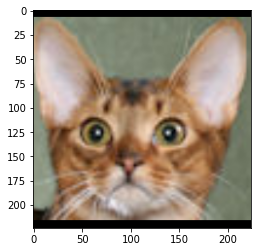

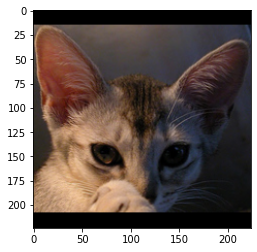

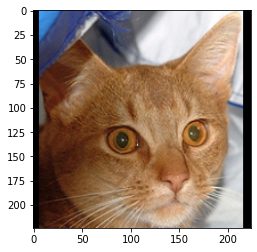

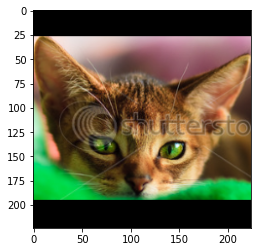

In [35]:
for i in range(4):
    plt.figure()
    plt.imshow(imagesBbx[i])

In [36]:
imagesBbx.shape

(7390, 224, 224, 3)

Todas as imagens foram convertidas para o tamanho especificado no pârametro ISize (224,224) com 3 channels.

<hr style="border:2px solid black"> </hr>

## Pre-processamento das imagens com padding e sem padding

 Como as imagens encontram-se com diferentes tamanhos, é necessário dar resize nas imagens para terem todas o mesmo tamanho.
 
 Para resize irá ser utilizado duas diferentes funções da biblioteca Image Processing do tensorflow, nomeadamente:
* tf.image.resize - Adiciona distorção às imagens se o aspect ratio original for diferente do novo
* tf.image.resize_with_pad - Adiciona um padding, tendo vantagem de não realizar distorção nas imagens
* É necessário converter as imagens para um array numpy uint8 de forma a converter a data da imagem para a gama [0,255]


O tamanho que está a ser utilizado para o tamanho das imagens é (224,224). Isto foi porque nos modelos pre-treinados do keras que vão ser utilizados o input_shape por default é também (224,224), o que será favorável para os resultados obtidos com estes modelos.

In [17]:
def load_image_resize(imageNames,PATH_IMGS, addPad=True):

    imageData = []
    #load das imagens
    for name in (imageNames):
        img = load_img(os.path.join(PATH_IMGS, name))
        if (addPad):
            #adicionar resize com padding, necessario converter cada imagem para um array uint8
            img = tf.image.resize_with_pad(img_to_array(img, dtype = 'uint8'), ISize[0],ISize[1] ).numpy().astype('uint8')
        else:
            #adicionar resize sem padding, necessario converter cada imagem para um array uint8
            img = tf.image.resize(img_to_array(img, dtype = 'uint8'), [ISize[0],ISize[1]]).numpy().astype('uint8')
        imageData.append(img)
    
    imageData = np.array(imageData)
    return imageData


### Carregar imagens com Padding

In [47]:
imageData = load_image_resize(imageNames,PATH_IMGS, addPad=True)

#### Exemplo de imagem com padding

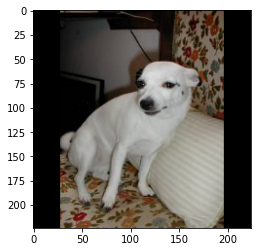

In [48]:
img = imageData[2015]
plt.imshow(img)

Como se pode observar na seguinte imagem, a imagem não ficou distorcida devido à adição do padding para caber no tamanho padrão definido para as imagens.

### Carregar imagens sem Padding

In [20]:
imageDataNoPad = load_image_resize(imageNames,PATH_IMGS, addPad=False)

#### Exemplo de imagem sem padding

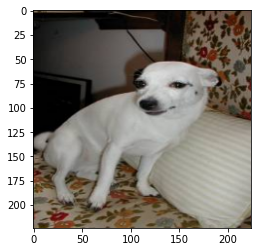

In [19]:
imgNoPad = imageDataNoPad[2015]
plt.imshow(imgNoPad)

Como se pode observar na seguinte imagem, a imagem ficou distorcida devido a ter que ficar esticada para caber no tamanho predefinido das imagens.

<hr style="border:2px solid black"> </hr>

## Gravar as imagens para os ficheiros

No processo de treino das redes neuronais, as imagens vão ser lidas de ficheiros a partir da função flow_from_directory do ImageDataGenerator. 

Esta função requere:
* As imagens têm que estar guardadas em ficheiros, dividadas em pastas de treino e teste.
* Cada pasta de treino e teste tem de ter internamente pastas onde as imagens estão divididas por classe.

Irá ser necessário criar datasets para as imagens pre-processadas para classificação binária e multi-classe.


<hr style="border:2px solid black"> </hr>

## Criar diferentes diretorias para dados de treino e teste para multi-classe

A função, saveToFolder, é uma função auxiliar que permite gravar as imagens nas diretorias especificas com os nomes corrertos. 

* Para gravar as imagens é utilizada a função save_img do tensorflow que permite guardar imagens a partir de um Numpy array.
* Esta função permite também gerar automáticamente as diretorias de treino e de teste para o dataset.

In [21]:
def saveToFolder(imgName,isTrain, class_name,image,isMulti,baseFolderBin,baseFolder):
    
    if (isMulti==False):
        
        target_path_train = os.path.join(baseFolderBin,'train')
        target_path_test = os.path.join(baseFolderBin,'test')

        if (os.path.isdir(target_path_train)==False ):
            os.mkdir(target_path_train)
    
        if(os.path.isdir(target_path_test)==False):
            os.mkdir(target_path_test)
    
    else:
        
        target_path_train = os.path.join(baseFolder,'train')
        target_path_test = os.path.join(baseFolder,'test')

        if (os.path.isdir(target_path_train)==False ):
            os.mkdir(target_path_train)
    
        if(os.path.isdir(target_path_test)==False):
            os.mkdir(target_path_test)
        
    if (isTrain):
        class_path = os.path.join(target_path_train,class_name)
        if (os.path.isdir(class_path)==False):
            os.mkdir(class_path)
        target_path = os.path.join(class_path,imgName)
        save_img(target_path, image)
        
    else:
        class_path = os.path.join(target_path_test,class_name)
        if (os.path.isdir(class_path)==False):
            os.mkdir(class_path)
        target_path = os.path.join(class_path,imgName)
        save_img(target_path, image)
    

Esta função passa as imagens da diretoria base para diretorias separadas. As imagens são processadas e guardadas nos ficheiros específicos. As imagens no images ja estão pre-processadas.

Esta função, create_train_test_directorys, permite criar as diretorias de treino e de teste ambas para a classificação binária e multi-classe, chamando a função auxiliar saveToFolder.

* A função percorre todas as imagens, caso a imagem seja de treino é guardada na diretoria de treino devidamente, caso contrário a imagem é guardada na diretoria de teste.

In [22]:
def create_train_test_directorys(isMulti, images,imageNames,files,baseFolderBin,baseFolder):

    if (isMulti):
    #base directory path
        base_path = "images_generation/images_generation"
    else:
        base_path = "images_generation_bin/images_generation_bin"
        
    #create test and train directories
    
    train_path = os.path.join(base_path,'train')
    test_path = os.path.join(base_path,'test')
    
    # se ainda nao existe a diretoria para treino e teste, criar
    if (os.path.isdir(train_path)==False ):
        os.mkdir(train_path)
    
    if(os.path.isdir(test_path)==False):
        os.mkdir(test_path)

    for i in range(len(imageNames)):
        if (isMulti):
            if (files[imageNames[i]]["foldTrain"]):
                #ler imagem e dar save no sitio certo
                saveToFolder(imageNames[i],True,files[imageNames[i]]["breed"],images[i],True,baseFolderBin,baseFolder)
                
            else:
                #ler imagem e dar save no sitio certo
                saveToFolder(imageNames[i],False,files[imageNames[i]]["breed"],images[i],True,baseFolderBin,baseFolder)
        
        else:
            if (files[imageNames[i]]["foldTrain"]):
                #ler imagem e dar save no sitio certo
                saveToFolder(imageNames[i],True,files[imageNames[i]]["species"],images[i],False,baseFolderBin,baseFolder)
            else:
                #ler imagem e dar save no sitio certo
                saveToFolder(imageNames[i],False,files[imageNames[i]]["species"],images[i],False,baseFolderBin,baseFolder)
    


A seguinte função, predict, irá ser utilizada para obter a matriz de confusão dado um modelo pre-treinado.

In [23]:
# shows the confusion matrix and the accuracy
def predict(cnn, testGen, classesNames, plot_matrix_color=False):
    
    y2e=cnn.predict(testGen,steps=(3704//bSize) +1,verbose=1)
    Y2=np.argmax(y2e,axis=1)
    
    M2=confusion_matrix(testGen.classes, Y2)
    print(M2)
    if plot_matrix_color:
        plot_confusion_matrix(M2, classesNames)
    print("%d erros em %d exemplos"%(np.sum(testGen.classes!=Y2),testGen.classes.shape[0]))
    print("%Accuracy:",(100-np.sum(testGen.classes!=Y2)*100/testGen.classes.shape[0]))

###  Definir as diretorias onde vão ser guardadas as diferentes imagens dos diferentes conjuntos de dados

Vão ser criadas diretorias novas para os seguintes conjunto de dados:
* Imagens com padding
* Images sem padding
* Imagens com bounding box no conjunto de treino

### Paths para as diretorias criadas

Diretorias para imagens com padding

In [ ]:
base_folder_multi_padding="images_generation/images_generation"

In [ ]:
base_folder_bin_padding="images_generation/images_generation_bin"

Diretorias para imagens sem padding

In [37]:
base_folder_multi_no_padding="images_generation_no_pad/images_generation_no_pad"

In [25]:
base_folder_bin_no_padding="images_generation_no_pad_bin/images_generation_no_pad_bin"

Diretorias para imagens com bounding box

In [26]:
base_folder_multi_bbx="images_generation_bbx/images_generation_bbx"

In [27]:
base_folder_bin_bbx="images_generation_bbx_bin/images_generation_bbx_bin"

### Criar diretorias para as imagens binárias geradas

* criar diretoria binária com padding:

In [136]:
create_train_test_directorys(False, imageData,imageNames,files, base_folder_bin_padding,base_folder_multi_padding)

images_generation_bin/images_generation_bin\train


* criar diretoria binária sem padding:

In [38]:
create_train_test_directorys(False, imageDataNoPad,imageNames,files, base_folder_bin_no_padding,base_folder_multi_no_padding)

* criar diretoria binária com bounding box e padding:

In [39]:
create_train_test_directorys(False, imagesBbx,imageNames,files, base_folder_bin_bbx,base_folder_multi_bbx)

### Criar diretorias para as imagens multi-classe geradas

* criar diretoria multi-classe com padding:

In [137]:
create_train_test_directorys(True, imageData, imageNames,files, base_folder_bin_padding,base_folder_multi_padding)

images_generation/images_generation\train


* criar diretoria multi-classe sem padding:

In [40]:
create_train_test_directorys(True, imageDataNoPad, imageNames,files, base_folder_bin_no_padding,base_folder_multi_no_padding)

* criar diretoria multi-classe com bounding box e padding:

In [41]:
create_train_test_directorys(True, imagesBbx, imageNames,files, base_folder_bin_bbx,base_folder_multi_bbx)

### Criação de callbacks early stopping

Utilizou-se callback early stopping para parar o treino se não houver nenhuma melhoria na loss, val_loss, accuracy, val_accuracy por 10 EPOCHS consecutivas.

In [37]:
callbacks = [
    tf.keras.callbacks.EarlyStopping(patience=10,monitor="val_loss",verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=10,monitor="loss",verbose=1),
    tf.keras.callbacks.EarlyStopping(patience=10,monitor="accuracy",verbose=1, restore_best_weights=True),
    tf.keras.callbacks.EarlyStopping(patience=10,monitor="val_accuracy",verbose=1)

]

### Diretoria para obter as imagens

In [75]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dbDir = "images_generation/images_generation"

<hr style="border:2px solid black"> </hr>

# Treino MultiClasse

Inicialmente começou-se por realizar o processo de classificação multi-classe.

O conjunto de dados fornecido tem um conjunto de 37 diferentes classes.

Nesta etapa vão ser relatados os resultados obtidos com:
* Diferentes classificadores com e sem data augmentation .
* Diferentes redes pre-treinadas e redes já treinadas de raiz.
* Diferentes formas de processamento dos dados mencionadas anteriormente.

**Inicialmente o conjunto de dados testado foi o das imagens com padding, sem bounding box.**

## Data generator for data augmentation

Inicialmente começou-se por testar como o uso de técnicas de data augmentation aumenta o desempenho dos classificadores.

Data Augmentation consiste em aumentar o número de exemplos do conjunto de dados a partir de transformações aos dados originais. 

Teve-se o cuidado de certificar que as imagens resultantes são o mais realistas quanto possível. Desta maneira, o modelo vê muitas versões diferentes dos exemplos originais, e é exposto a mais aspectos dos dados. Isto ajuda à generalização.

As transformações aleatórias realizadas nas imagens foram as seguintes:

* rescale dos dados para normalizar entre 0 e 1.
* rotação com rotação máxima de 30 º.
* shift aleatório maximo  de 0.2
* shear e zoom de 0.2

Estes valores foram testados, e estavam a oferecer bons resultados para o processo de data augmentation, adicionando um bom nível de aleatoriadade aos dados mantendo um bom nível de realismo.

### Image Data Generator

* A classe ImageDataGenerator do tensorflow permite aplicar um conjunto de transformações ao conjunto de dados inteiro, sendo utilizada então para carregar os dados e realizar as transformações da data augmentation.

* Para dar load dos dados utilizou-se o  método .flow_from_directory() do Keras, que permite passar os dados para o gerador de treino e teste, passando as imagens diretamente das diretorias criadas, eliminando a necessidade de precisar de ter que as salvar em memória.

* O ImageDataGenerator é utilizado para a geração de batches que contêm os dados de imagens do tensorflow e é utilizado no domínio de data augmentation em tempo real.

* O número de imagens geradas em cada iteração do treino vai depender do batch size, que foi definido inicialmente como **10**.

In [41]:
train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               fill_mode = 'nearest')


train_data = train_gen.flow_from_directory(directory=dbDir+"/train",
target_size=ISize,class_mode="categorical", batch_size=bSize)

Found 3686 images belonging to 2 classes.


### Image Data Generator para dados de teste

In [42]:
test_gen = ImageDataGenerator(rescale = 1./255)

test_data = test_gen.flow_from_directory(directory=dbDir+"/test",
target_size=ISize,class_mode="categorical", batch_size=bSize, shuffle=False)

Found 3704 images belonging to 2 classes.


In [43]:
train_gen_without = ImageDataGenerator(rescale = 1./255)


train_data_without = train_gen_without.flow_from_directory(directory=dbDir+"/train",
target_size=ISize,class_mode="categorical", batch_size=bSize)

Found 3686 images belonging to 2 classes.


### Funções auxiliares para obter o gerador de treino e de teste

As seguintes funções auxiliares permitem retornar os dados obtidos a partir do gerador de treino e do conjunto de dados, quer para o treino ou para o teste.

In [49]:
def get_train_data(directoryTrain):
    train_gen = ImageDataGenerator(rescale = 1./255,
                               rotation_range = 30,
                               width_shift_range = 0.2,
                               height_shift_range = 0.2,
                               shear_range = 0.2,
                               zoom_range = 0.2,
                               horizontal_flip = True,
                               fill_mode = 'nearest')


    return train_gen.flow_from_directory(directory=directoryTrain+"/train",
        target_size=ISize,class_mode="categorical", batch_size=bSize)

In [50]:
def get_test_data(directoryTest):
    
    test_gen = ImageDataGenerator(rescale = 1./255)

    return test_gen.flow_from_directory(directory=directoryTest+"/test",
        target_size=ISize,class_mode="categorical", batch_size=bSize, shuffle=False)

## Desmonstrar as imagens geradas a partir da data augmentation

De seguida podem ser observadas as imagens obtidas a partir do processo de data augmentation.

* É possível visualizar as diferentes transformações aleatórias aplicadas a uma imagem.

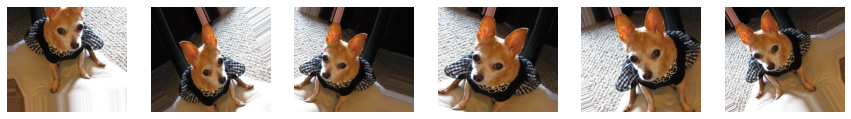

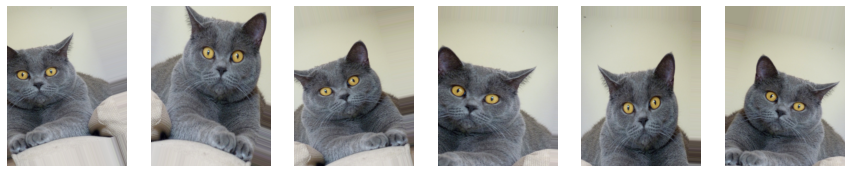

In [32]:
from keras.preprocessing import image


#MOSTRAR CAO
fN = "images/images/chihuahua_53.jpg"

I=image.load_img(fN,ISize)
I=image.img_to_array(I)

I=I[np.newaxis,:,:,:]

n=0
#alterei
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,15))

for A in train_gen.flow(I,batch_size=1):
    A=A.squeeze() 
    A=A-A.min()
    A=A/A.max()*255
    
    #alterei
    ax[n].imshow(np.uint8(A))
    ax[n].axis('off')
    
    #alterei 
    n+=1
    if n>5:
        break

#MOSTRAR GATO

fN = "images/images/British_Shorthair_58.jpg"

I=image.load_img(fN,ISize)
I=image.img_to_array(I)

I=I[np.newaxis,:,:,:]

n=0
#alterei
fig, ax = plt.subplots(nrows=1, ncols=6, figsize=(15,15))

for A in train_gen.flow(I,batch_size=1):
    A=A.squeeze() 
    A=A-A.min()
    A=A/A.max()*255
    
    #alterei
    ax[n].imshow(np.uint8(A))
    ax[n].axis('off')
    
    #alterei 
    n+=1
    if n>5:
        break




As imagens originais escolhidas como exemplo foi a imagem de um cão e de um gato. Como se pode observar as imagens diferem entre si em parâmetros aleatóriamente como:
* rotação
* zoom
* translação


<hr style="border:2px solid black"> </hr>

## Treinar rede neuronal sem modelo pre treinado do Keras

A primeira rede neuronal irá ser treinada sem um modelo pre treinado do Keras.

Nesta rede está ser utilizado:

* Modelo Sequencial
* Conv2D (Camadas convulocionais 2D)
* MaxPooling2D
* Camadas Dropout
* Camada Flatten
* Camada dense com função de activação 'softmax' para o Output

**Max pooling** reduz a dimensionalidade de imagens, reduzindo o número de pixeis no ouput da camada convolucional anterior. Devido a isto, oferece as seguintes vantagens:
* Reduzir carga computacional 
* Reduzir overfitting


Também poderia ter sido utilizado average pooling, onde é considerado o valor médio de cada região em vez de o máximo, mas MaxPooling obteu melhores resultados.



Testou-se também a adição de camadas de **dropout**. A partir de diferentes testes o melhor valor para a dropout rate foi 0.2. 

A Dropout layer mete de forma aleatória as unidades de input para 0 com uma frequência (dropout rate) em cada step do processo de treino, isto ajuda a prevenir overfitting.


In [ ]:
model4 = keras.Sequential()
model4.add(keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(ISize[0], ISize[0],3)))
model4.add(keras.layers.MaxPooling2D(pool_size=2))

model4.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model4.add(keras.layers.MaxPooling2D(pool_size=2))
model4.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model4.add(keras.layers.MaxPooling2D(pool_size=2))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model4.add(keras.layers.MaxPooling2D(pool_size=2))
model4.add(keras.layers.Dropout(0.2))
model4.add(keras.layers.Flatten())
model4.add(keras.layers.Dense(512, activation='relu'))

model4.add(keras.layers.Dense(37,activation='softmax'))

In [159]:
model4.compile(optimizer="nadam", loss="categorical_crossentropy",metrics=["accuracy"])

In [161]:
ePochs = 60
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = model4.fit(train_data,steps_per_epoch=speTrain,validation_data=test_data,validation_steps=speValid,epochs=ePochs)

Epoch 1/60
368/368 [==============================] - 40s 108ms/step - loss: 3.3969 - accuracy: 0.0868 - val_loss: 3.3063 - val_accuracy: 0.0989
Epoch 2/60
368/368 [==============================] - 40s 108ms/step - loss: 3.2769 - accuracy: 0.1061 - val_loss: 3.2424 - val_accuracy: 0.1162
Epoch 3/60
368/368 [==============================] - 40s 109ms/step - loss: 3.2006 - accuracy: 0.1194 - val_loss: 3.2055 - val_accuracy: 0.1205
Epoch 4/60
368/368 [==============================] - 40s 108ms/step - loss: 3.1537 - accuracy: 0.1328 - val_loss: 3.1268 - val_accuracy: 0.1435
Epoch 5/60
368/368 [==============================] - 40s 109ms/step - loss: 3.0898 - accuracy: 0.1442 - val_loss: 3.0958 - val_accuracy: 0.1486
Epoch 6/60
368/368 [==============================] - 40s 107ms/step - loss: 3.0357 - accuracy: 0.1589 - val_loss: 3.0738 - val_accuracy: 0.1535
Epoch 7/60
368/368 [==============================] - 40s 109ms/step - loss: 2.9813 - accuracy: 0.1779 - val_loss: 3.2092 - val_ac

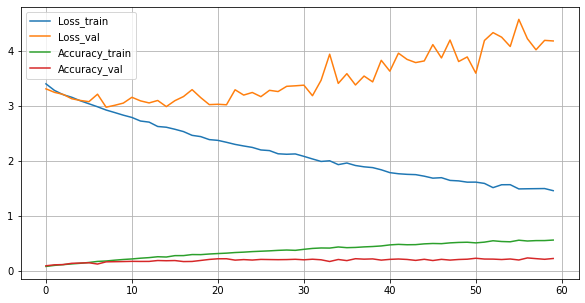

In [162]:
get_train_history(train)

* A partir da observação da evolução das linhas da accuracy para treino e teste é possível observar que o modelo começa a entrar em sobre-aprendizagem, visto que começa a haver uma grande dispersão entre o conjunto de treino e o de validação.

* Outro sinal de sobre-aprendizagem é a loss a diminuir progressivamente no conjunto de treino e a loss a aumentar no conjunto de validação.

* A partir da observação do gráfico da accuracy de validação pode-se notar que a partir da EPOCH 40 o modelo encontra-se bastante estavél, portanto não seriam necessárias tantas EPOCHS.


371/371 [==============================] - 5s 14ms/step
[[11  8  1 ...  0  0  1]
 [ 5 37  0 ...  2  1  5]
 [ 0  0 28 ...  0  0  0]
 ...
 [ 1  2  0 ...  4  0  0]
 [ 2  0  1 ...  0 11  1]
 [ 5  2  1 ...  0  1  9]]
Confusion matrix, without normalization
2850 erros em 3704 exemplos
%Accuracy: 23.056155507559396


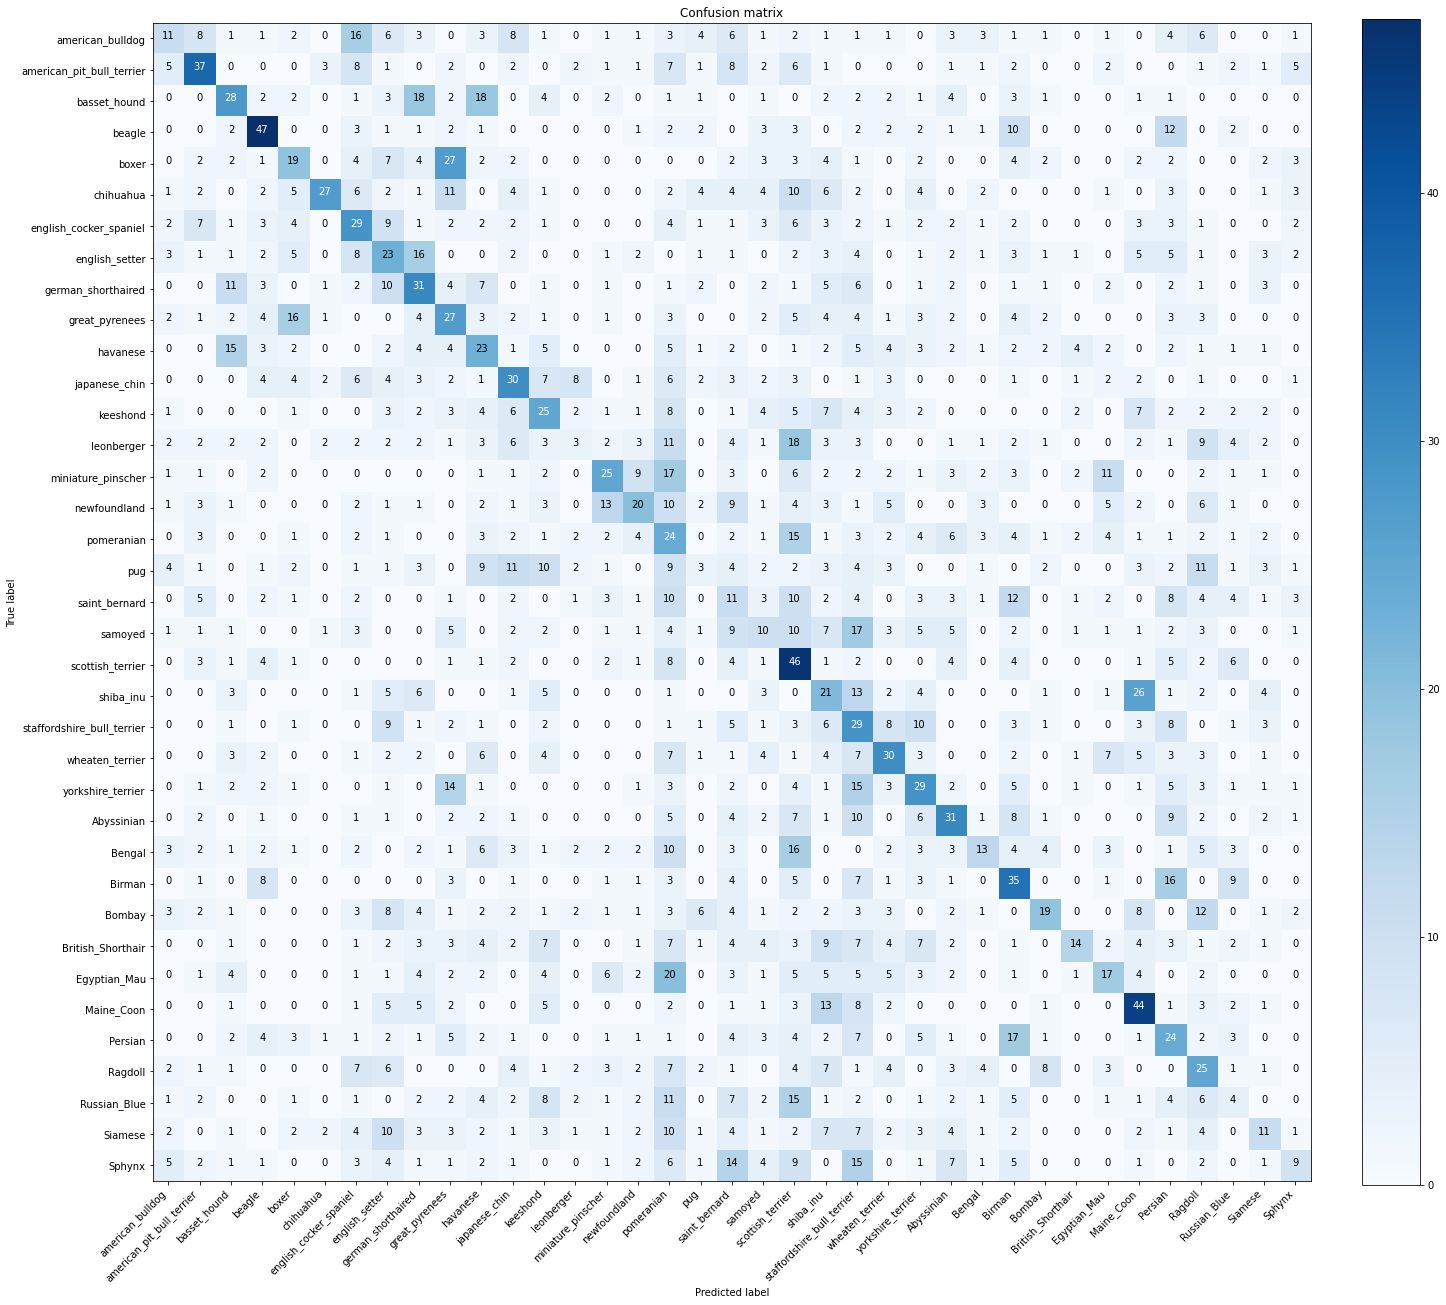

In [163]:
predict(model4, test_data,classesNames,plot_matrix_color=True)

* O modelo obteve para o conjunto de teste uma accuracy de : **0.23**
* De seguida vai ser criada outra rede neuronal sem modelo pre treinado do Keras, treinada com parâmetros diferentes para averiguar qual obtém melhores resultados.

In [164]:
model4.save('models/modelMultiMine')
#saved_model = tf.keras.models.load_model('models/pet_image_classifier')
#sm_test_loss, sm_test_acc = saved_model.evaluate(test_data, verbose = 0)

INFO:tensorflow:Assets written to: models/modelMultiMine\assets


<hr style="border:2px solid black"> </hr>

## Segunda rede neuronal sem modelo pré-treinado do Keras treinada

Nesta rede neuronal foi testado se a adição de mais camadas convulocionais 2D é benéfico para os resultados obtidos do modelo. Foi também testada a adição de mais camadas de dropout, de forma a tentar evitar demasiado overfitting.

In [87]:
model5 = keras.Sequential()
model5.add(keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(ISize[0], ISize[0],3)))
model5.add(keras.layers.MaxPooling2D(pool_size=2))

model5.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=2))
model5.add(keras.layers.Dropout(0.05))
           
model5.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=2))
model5.add(keras.layers.Dropout(0.1))
           
model5.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=2))
model5.add(keras.layers.Dropout(0.25))
           
model5.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=2))
model5.add(keras.layers.Dropout(0.25))          
          
model5.add(keras.layers.Flatten())
model5.add(keras.layers.Dense(512, activation='relu'))
           
model5.add(keras.layers.Dense(37,activation='softmax'))

In [88]:
model5.compile(optimizer="nadam", loss="categorical_crossentropy",metrics=["accuracy"])

In [97]:
ePochs = 40
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = model5.fit(train_data,steps_per_epoch=speTrain,validation_data=test_data,validation_steps=speValid,epochs=ePochs)

Epoch 1/40
368/368 [==============================] - 41s 112ms/step - loss: 2.4751 - accuracy: 0.2816 - val_loss: 2.9520 - val_accuracy: 0.2043
Epoch 2/40
368/368 [==============================] - 41s 111ms/step - loss: 2.4596 - accuracy: 0.2922 - val_loss: 2.8759 - val_accuracy: 0.2289
Epoch 3/40
368/368 [==============================] - 41s 110ms/step - loss: 2.4748 - accuracy: 0.2840 - val_loss: 2.9645 - val_accuracy: 0.1965
Epoch 4/40
368/368 [==============================] - 41s 110ms/step - loss: 2.4248 - accuracy: 0.3098 - val_loss: 3.1618 - val_accuracy: 0.1951
Epoch 5/40
368/368 [==============================] - 41s 112ms/step - loss: 2.3922 - accuracy: 0.3022 - val_loss: 2.8811 - val_accuracy: 0.2270
Epoch 6/40
368/368 [==============================] - 41s 111ms/step - loss: 2.3726 - accuracy: 0.3180 - val_loss: 3.0911 - val_accuracy: 0.1914
Epoch 7/40
368/368 [==============================] - 40s 110ms/step - loss: 2.3582 - accuracy: 0.3164 - val_loss: 2.9217 - val_ac

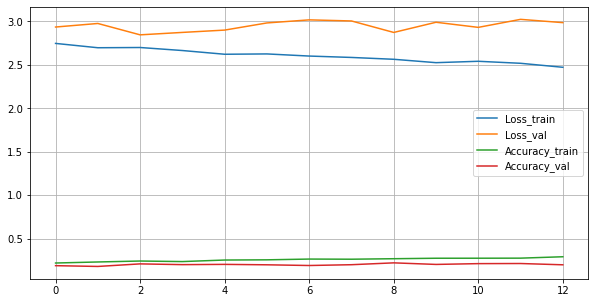

In [94]:
get_train_history(train)

É possivel determinar que o modelo já não está em overfitting, visto que a accuracy entre treino e validation encontra-se muito próxima. Os valores de loss encontram-se bastante estáveis para o conjunto de validação, mas está a começar a descer para o conjunto de treino, então não parece ser muito favorável a adição de mais EPOCHS.

371/371 [==============================] - 5s 14ms/step
[[24  9  1 ...  1  4  4]
 [ 8 30  0 ...  7  1  3]
 [ 0  1 34 ...  1  3  0]
 ...
 [ 2  2  0 ...  9  1  1]
 [ 0  3  0 ...  2 14  1]
 [ 2 21  0 ...  2  1  6]]
Confusion matrix, without normalization
2972 erros em 3704 exemplos
%Accuracy: 19.762419006479476


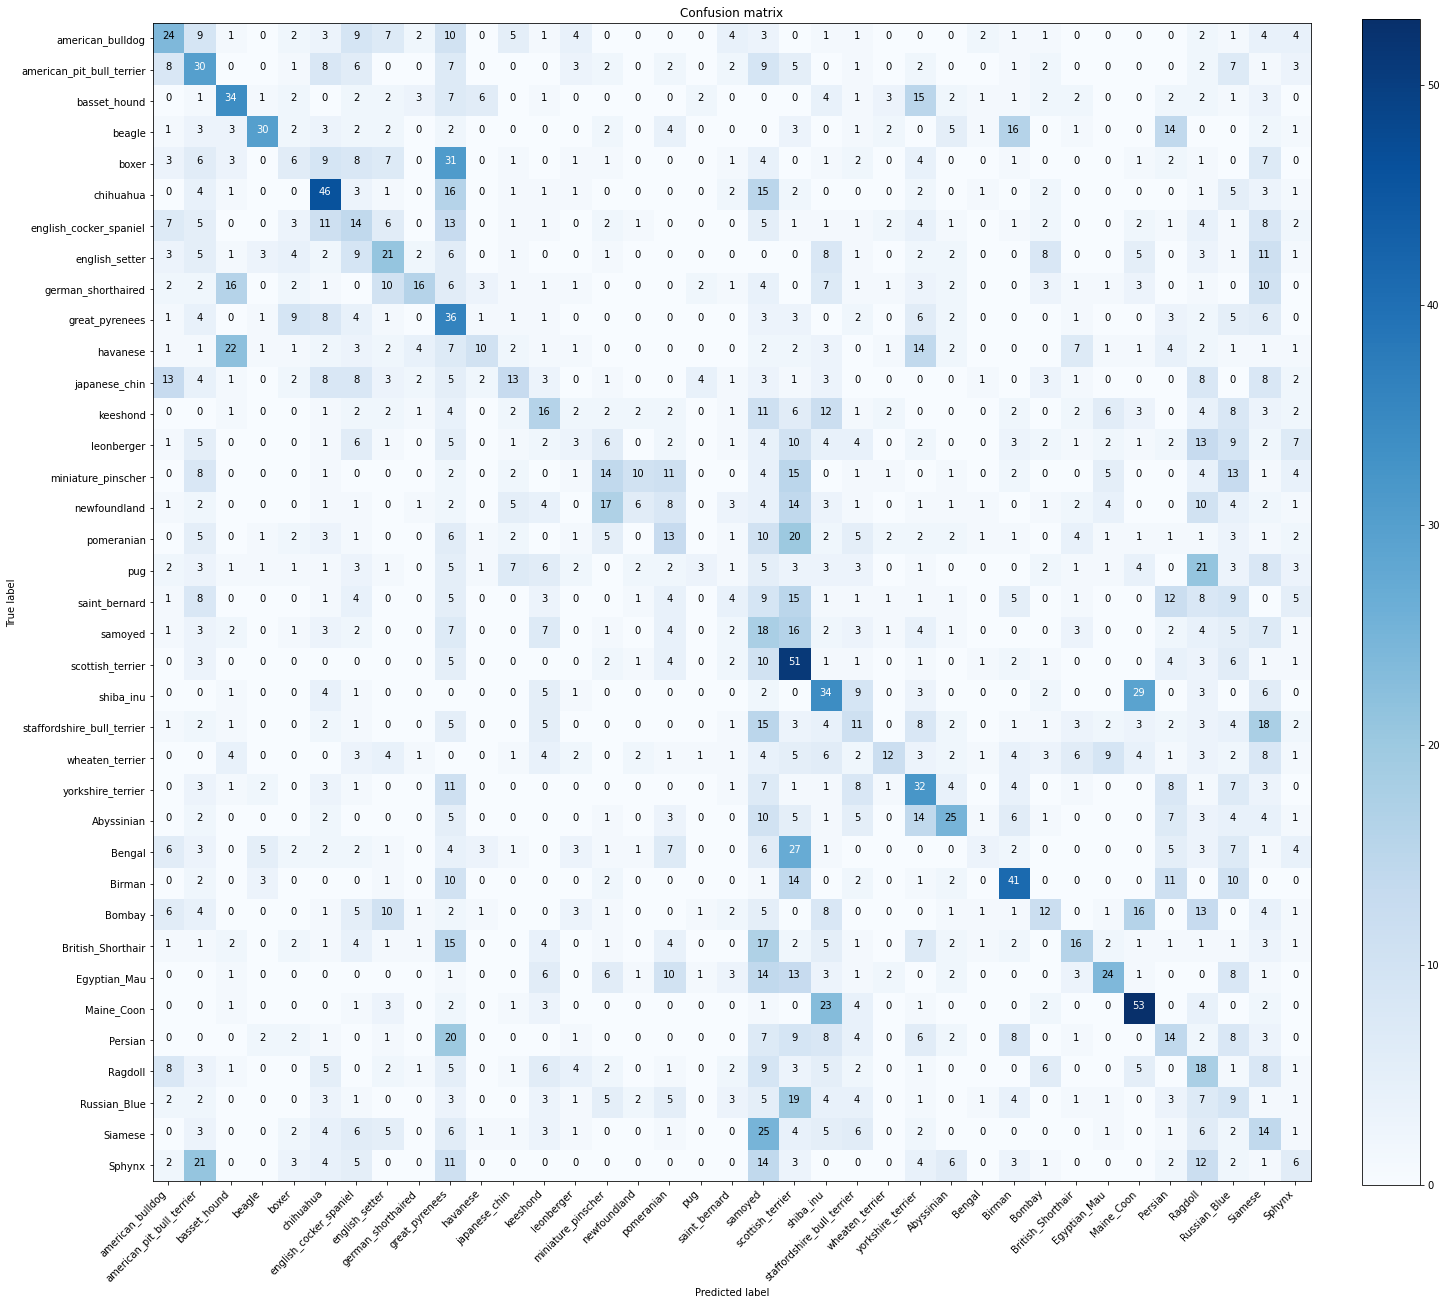

In [95]:
predict(model5, test_data,classesNames,plot_matrix_color=True)

* O modelo obteve para o conjunto de teste uma accuracy de : **0.19**.
* O modelo não entrou em sobre-aprendizagem como o anterior, mas obteve resultados menos favoráveis.
* De seguida vai ser criada outra rede neuronal sem modelo pre treinado do Keras treinada sem a data augmentation.

In [96]:
model5.save('models/modelMultiMine2')
#saved_model = tf.keras.models.load_model('models/pet_image_classifier')
#sm_test_loss, sm_test_acc = saved_model.evaluate(test_data, verbose = 0)

INFO:tensorflow:Assets written to: models/modelMultiMine2\assets


<hr style="border:2px solid black"> </hr>

## Treinar modelo multi-classe sem data augmentation

* De seguida vai ser testado um modelo multi-classe sem data augmentation para verificar se a data augmentation está ou não a ser benéfica.

* Utilizou-se um modelo semelhante ao anterior de forma a comparação com e sem data-augmentation ser justa.

In [79]:
model5 = keras.Sequential()
model5.add(keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(ISize[0], ISize[0],3)))
model5.add(keras.layers.MaxPooling2D(pool_size=2))

model5.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=2))
model5.add(keras.layers.Dropout(0.05))
           
model5.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=2))
model5.add(keras.layers.Dropout(0.1))
           
model5.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=2))
model5.add(keras.layers.Dropout(0.25))
           
model5.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
model5.add(keras.layers.MaxPooling2D(pool_size=2))
model5.add(keras.layers.Dropout(0.25))          
          
model5.add(keras.layers.Flatten())
model5.add(keras.layers.Dense(512, activation='relu'))
           
model5.add(keras.layers.Dense(37,activation='softmax'))

In [80]:
model5.compile(optimizer="nadam", loss="categorical_crossentropy",metrics=["accuracy"])

In [86]:
ePochs = 40
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = model5.fit(train_data_without,steps_per_epoch=speTrain,validation_data=test_data,
                   validation_steps=speValid,epochs=ePochs,)

Epoch 1/40
368/368 [==============================] - 12s 31ms/step - loss: 0.2722 - accuracy: 0.9178 - val_loss: 6.5655 - val_accuracy: 0.1405
Epoch 2/40
368/368 [==============================] - 12s 31ms/step - loss: 0.2495 - accuracy: 0.9252 - val_loss: 7.1437 - val_accuracy: 0.1500
Epoch 3/40
368/368 [==============================] - 11s 31ms/step - loss: 0.2026 - accuracy: 0.9410 - val_loss: 7.4262 - val_accuracy: 0.1446
Epoch 4/40
368/368 [==============================] - 11s 31ms/step - loss: 0.1693 - accuracy: 0.9480 - val_loss: 8.0007 - val_accuracy: 0.1397
Epoch 5/40
368/368 [==============================] - 12s 31ms/step - loss: 0.2161 - accuracy: 0.9336 - val_loss: 7.6144 - val_accuracy: 0.1468
Epoch 6/40
368/368 [==============================] - 12s 33ms/step - loss: 0.1631 - accuracy: 0.9505 - val_loss: 7.8632 - val_accuracy: 0.1411
Epoch 7/40
368/368 [==============================] - 12s 31ms/step - loss: 0.1439 - accuracy: 0.9584 - val_loss: 8.8709 - val_accuracy:

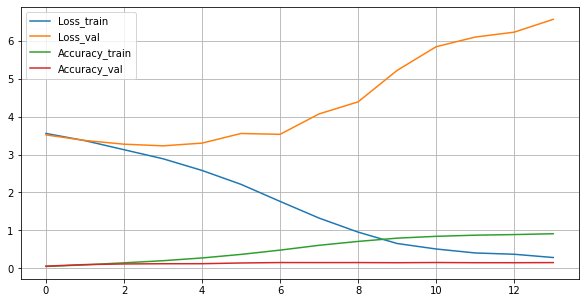

In [83]:
get_train_history(train)

A partir dos resultados obtidos para a accuracy de treino e de validação é de notar que o modelo está a entrar em sobre-aprendizagem. Seria de notar que a partir da EPOCH 4 o modelo começa a ter uma grande dispersão na loss de validação e de treino, seria então ter sido favorável parar o treino numa EPOCH perto do 4.

371/371 [==============================] - 4s 11ms/step
[[ 6  4  1 ...  0  1 10]
 [ 5  7  1 ...  4  0 12]
 [ 1  1 22 ...  1  2  3]
 ...
 [ 0  2  0 ... 12  1  2]
 [ 1  3  1 ...  3  7  3]
 [ 2  4  0 ...  4  2  8]]
Confusion matrix, without normalization
3146 erros em 3704 exemplos
%Accuracy: 15.06479481641469


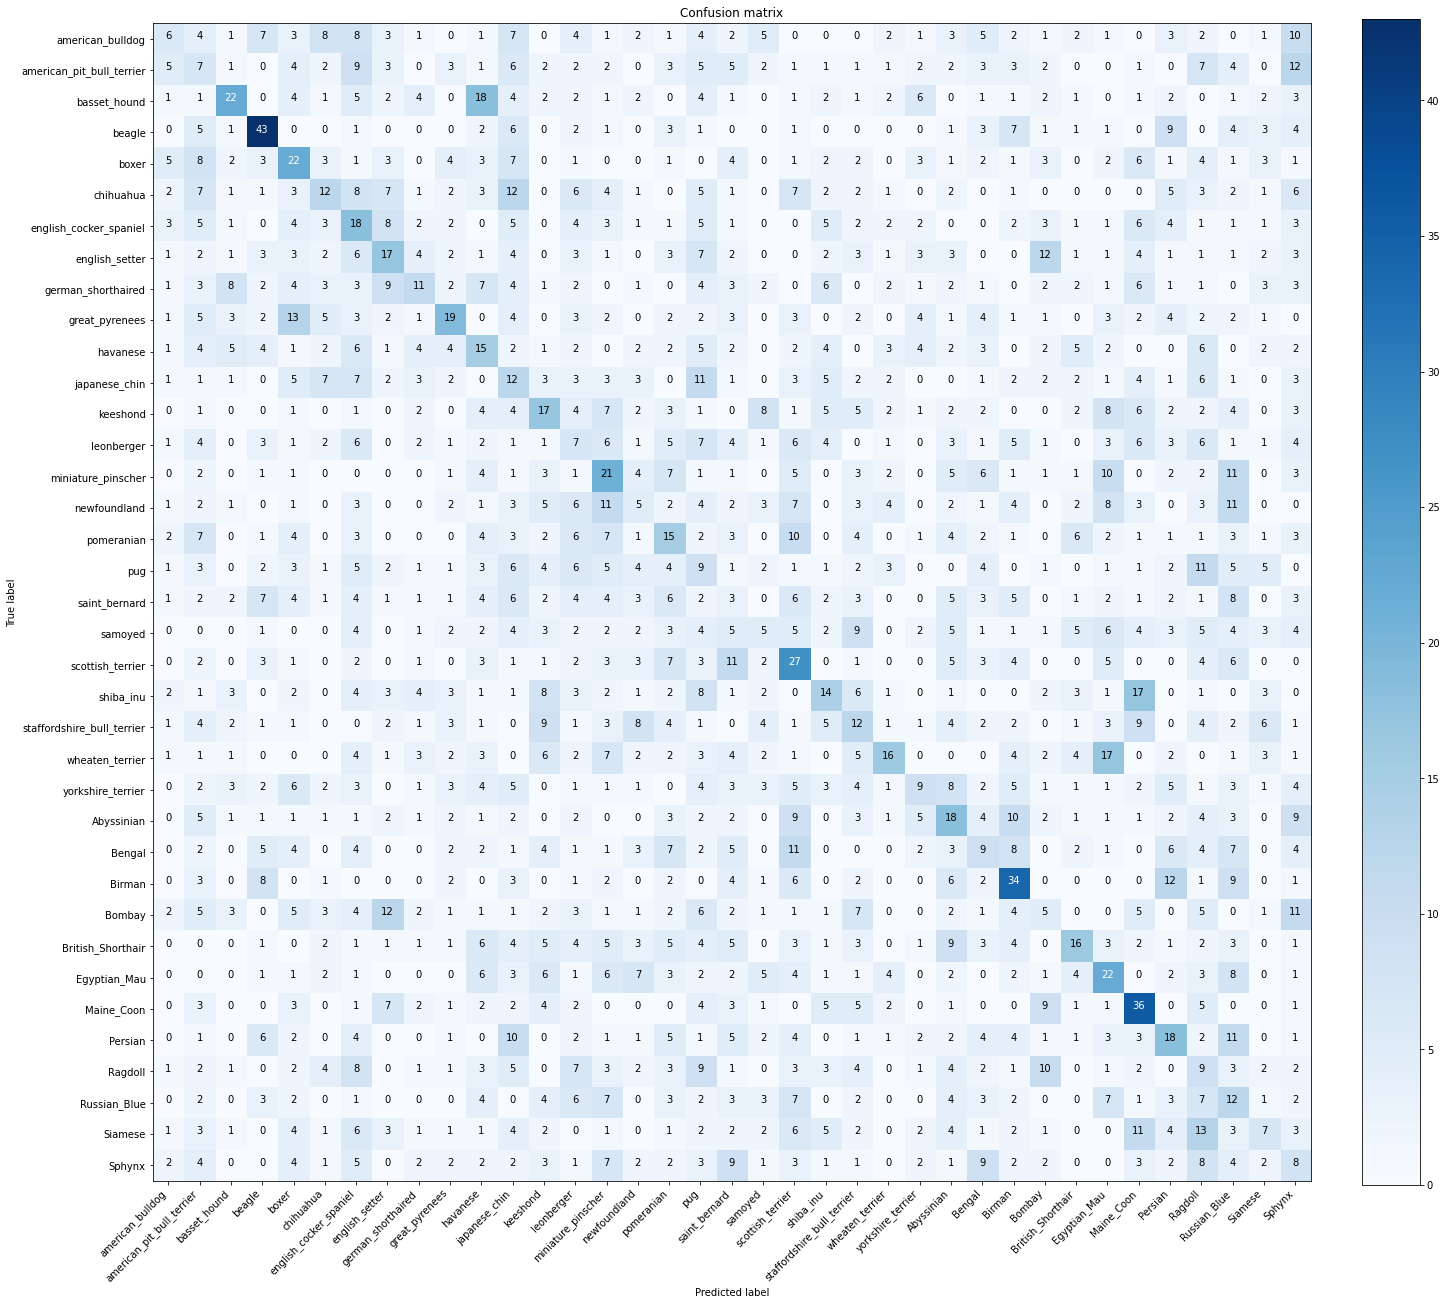

In [84]:
predict(model5, test_data,classesNames,plot_matrix_color=True)

* O modelo apenas obteve uma accuracy de **0.15**
* Os resultados obtidos com data augmentation foram superiores aos sem data augmentation. Isto resulta do modelo vêr muitas versões diferentes dos exemplos originais, e é exposto a mais aspectos dos dados, o que ajuda à generalização.

In [85]:
model5.save('models/modelMultiNoAug')

INFO:tensorflow:Assets written to: models/modelMultiNoAug\assets


<hr style="border:2px solid black"> </hr>

## Treinar utilizando modelos pré-treinados do keras

Há vários modelos pré-treinados disponíveis no Keras. Estes modelos são fácilmente carregados. De seguida vão ser testados e utilizados diferentes modelos.

Os modelos vão ser importados do Keras Applications com pesos pre-treinados. 

### Modelo Xception

O primeiro modelo do Keras com pesos pre-treinados testado foi o Xception.

* Este modelo foi escolhido devido a ter uma boa TOP-1 accuracy (79%) e TOP-5 accuracy (94.5%). O que refere à performance do modelo no dataset de validation do ImageNet.

* O modelo também só tem 88 (MB) de tamanho, sendo um modelo razoavelmente leve.


In [142]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.xception import preprocess_input
from keras.applications.xception import Xception

dataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input, 
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')
 

trainGen = dataGen1.flow_from_directory(directory=dbDir+"/train",
target_size=ISize,class_mode="categorical", batch_size=bSize)

Found 3686 images belonging to 37 classes.


In [143]:
dataGen2=ImageDataGenerator(preprocessing_function=preprocess_input)


testGen=dataGen2.flow_from_directory(directory=dbDir+"/test",
target_size=ISize,class_mode="categorical", batch_size=bSize, shuffle=False)

Found 3704 images belonging to 37 classes.


### Construção da rede neuronal com modelo pre-treinado.

Como o modelo já tem pesos pre-treinados, não é necessário fazer agora uma rede neuronal muito sofisticada para obter bons resultados, tendo apenas:
* Uma camada de MaxPooling2D
* Uma camada de Flatten
* Uma camada Dropout
* Uma camada Dense de output

In [144]:
from keras.applications.xception import Xception

cnnBase = Xception(weights="imagenet",include_top=False, input_shape=(ISize[0], ISize[1],3))
cnnBase.trainable=False

cnn3=keras.models.Sequential()
cnn3.add(cnnBase)
cnn3.add(keras.layers.MaxPooling2D((2, 2)))
cnn3.add(keras.layers.Flatten())
cnn3.add(keras.layers.Dropout(.3))
cnn3.add(keras.layers.Dense(37, activation="softmax"))

cnn3.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])

In [145]:
ePochs=40
speTrain=3686 //bSize
speValid=3704 //bSize
train = cnn3.fit(trainGen,steps_per_epoch=speTrain,validation_data=testGen,validation_steps=speValid,epochs=ePochs)

Epoch 1/40
368/368 [==============================] - 52s 136ms/step - loss: 2.5131 - accuracy: 0.6795 - val_loss: 2.1143 - val_accuracy: 0.7716
Epoch 2/40
368/368 [==============================] - 48s 132ms/step - loss: 2.0113 - accuracy: 0.8025 - val_loss: 2.2807 - val_accuracy: 0.8008
Epoch 3/40
368/368 [==============================] - 48s 131ms/step - loss: 1.7257 - accuracy: 0.8327 - val_loss: 2.7898 - val_accuracy: 0.8011
Epoch 4/40
368/368 [==============================] - 48s 131ms/step - loss: 1.5709 - accuracy: 0.8523 - val_loss: 2.6179 - val_accuracy: 0.8116
Epoch 5/40
368/368 [==============================] - 48s 130ms/step - loss: 1.5698 - accuracy: 0.8705 - val_loss: 2.5086 - val_accuracy: 0.8322
Epoch 6/40
368/368 [==============================] - 48s 130ms/step - loss: 1.5273 - accuracy: 0.8719 - val_loss: 2.5552 - val_accuracy: 0.8376
Epoch 7/40
368/368 [==============================] - 50s 135ms/step - loss: 1.4832 - accuracy: 0.8871 - val_loss: 3.0381 - val_ac

371/371 [==============================] - 14s 37ms/step
[[51  8  0 ...  0  0  0]
 [ 1 89  0 ...  0  0  0]
 [ 0  0 50 ...  0  0  0]
 ...
 [ 0  0  0 ... 55  0  0]
 [ 0  0  0 ...  0 82  0]
 [ 0  0  0 ...  0  0 98]]
Confusion matrix, without normalization
580 erros em 3704 exemplos
%Accuracy: 84.34125269978402


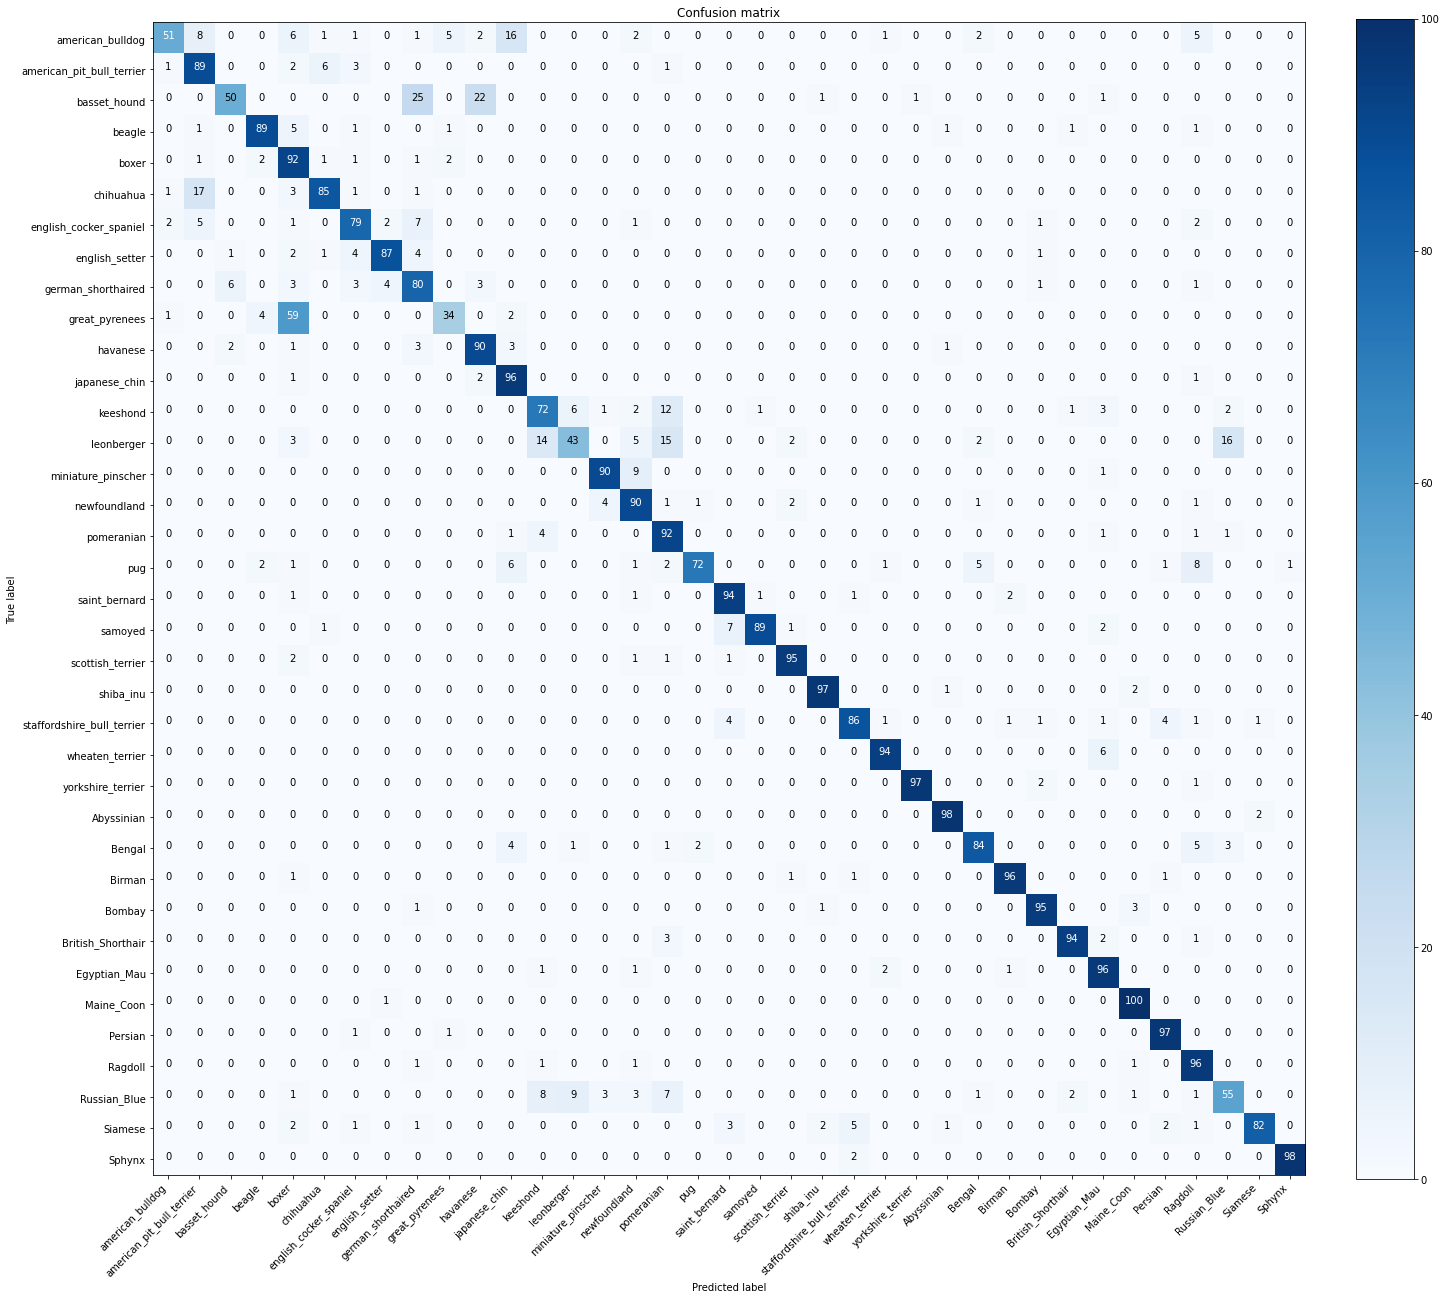

In [146]:
predict(cnn3, testGen,classesNames,plot_matrix_color=True)

* O modelo  obteve uma accuracy de **0.84**.
* Os resultados obtidos com modelo pre-treinado são muito mais superiores aos obtidos a partir das redes treinadas de raiz.
* Vai ser agora testado outro modelo pre-treinado.

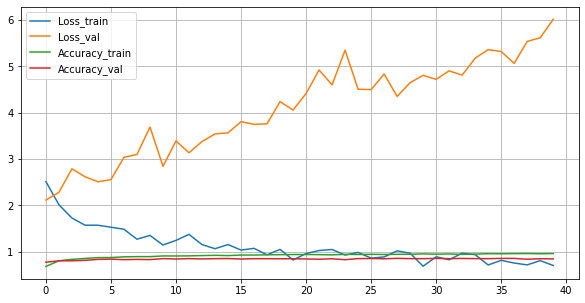

In [147]:
get_train_history(train)

A partir do gráfico é possível observar que os valores da accuracy de treino e de validação se encontram em evolução ao longo das diferentes EPOCHS, mantendo um nivel de accuracy entre treino e teste parecido.
É de notar que a partir da EPOCH 10 a loss do conjunto de validação começa a aumentar bastante enquanto a loss do conjuto de treino diminui. 
Seria de esperar que se o treino tivesse sido parado na EPOCH 10 os resultados poderiam ter sido semelhantes, evitando uma loss tão grande no conjunto de validação.

In [148]:
cnn3.save('models/modelMultiXception')

INFO:tensorflow:Assets written to: models/modelMultiXception\assets


<hr style="border:2px solid black"> </hr>

### Modelo ResNet101V2

O segundo modelo do Keras com pesos pre-treinados foi o ResNet101V2.

* Este modelo foi escolhido devido a ter uma boa TOP-1 accuracy (77.2%) e TOP-5 accuracy (93.8%). O que refere à performance do modelo no dataset de validation do ImageNet.

* O input shape das imagens nesta rede por default já é igual a (224, 224) o que torna este modelo bastante apelativo.


In [149]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from keras.applications.resnet_v2 import preprocess_input
from keras.applications.resnet_v2 import ResNet101V2


dataGen1 = ImageDataGenerator(preprocessing_function=preprocess_input, 
                               rotation_range = 30,
                               width_shift_range = 0.1,
                               height_shift_range = 0.1,
                               shear_range = 0.1,
                               zoom_range = 0.1,
                               horizontal_flip = True,
                               fill_mode = 'nearest')


trainGen = dataGen1.flow_from_directory(directory=dbDir+"/train",
target_size=ISize,class_mode="categorical", batch_size=bSize)

Found 3686 images belonging to 37 classes.


In [150]:
dataGen2=ImageDataGenerator(preprocessing_function=preprocess_input)


testGen=dataGen2.flow_from_directory(directory=dbDir+"/test",
target_size=ISize,class_mode="categorical", batch_size=bSize, shuffle=False)

Found 3704 images belonging to 37 classes.


In [151]:
cnnBase = ResNet101V2(weights="imagenet",include_top=False, input_shape=(ISize[0], ISize[1], 3))
cnnBase.trainable=False

cnnRes = keras.models.Sequential()
cnnRes.add(cnnBase)
cnnRes.add(keras.layers.MaxPooling2D((2, 2)))
cnnRes.add(keras.layers.Flatten())
cnnRes.add(keras.layers.Dropout(.3))
cnnRes.add(keras.layers.Dense(37, activation="softmax"))




cnnRes.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])

In [152]:
ePochs=40
speTrain=3686 //bSize
speValid=3704 //bSize
train = cnnRes.fit(trainGen,steps_per_epoch=speTrain,validation_data=testGen,validation_steps=speValid,epochs=ePochs)

Epoch 1/40
368/368 [==============================] - 64s 160ms/step - loss: 7.9273 - accuracy: 0.6164 - val_loss: 5.1696 - val_accuracy: 0.7649
Epoch 2/40
368/368 [==============================] - 57s 155ms/step - loss: 5.8051 - accuracy: 0.7729 - val_loss: 6.5765 - val_accuracy: 0.7778
Epoch 3/40
368/368 [==============================] - 57s 154ms/step - loss: 5.5468 - accuracy: 0.8093 - val_loss: 6.8976 - val_accuracy: 0.7976
Epoch 4/40
368/368 [==============================] - 57s 154ms/step - loss: 4.8800 - accuracy: 0.8425 - val_loss: 7.1640 - val_accuracy: 0.8119
Epoch 5/40
368/368 [==============================] - 57s 154ms/step - loss: 4.4659 - accuracy: 0.8615 - val_loss: 7.1380 - val_accuracy: 0.8232
Epoch 6/40
368/368 [==============================] - 57s 155ms/step - loss: 4.3010 - accuracy: 0.8700 - val_loss: 8.7199 - val_accuracy: 0.8038
Epoch 7/40
368/368 [==============================] - 57s 155ms/step - loss: 4.2142 - accuracy: 0.8760 - val_loss: 9.0198 - val_ac

371/371 [==============================] - 22s 57ms/step
[[94  1  0 ...  0  0  0]
 [ 7 76  0 ...  0  0  0]
 [ 0  0 63 ...  0  0  0]
 ...
 [ 0  0  0 ... 44  0  0]
 [ 0  0  0 ...  0 88  0]
 [ 0  0  0 ...  0  0 91]]
Confusion matrix, without normalization
571 erros em 3704 exemplos
%Accuracy: 84.5842332613391


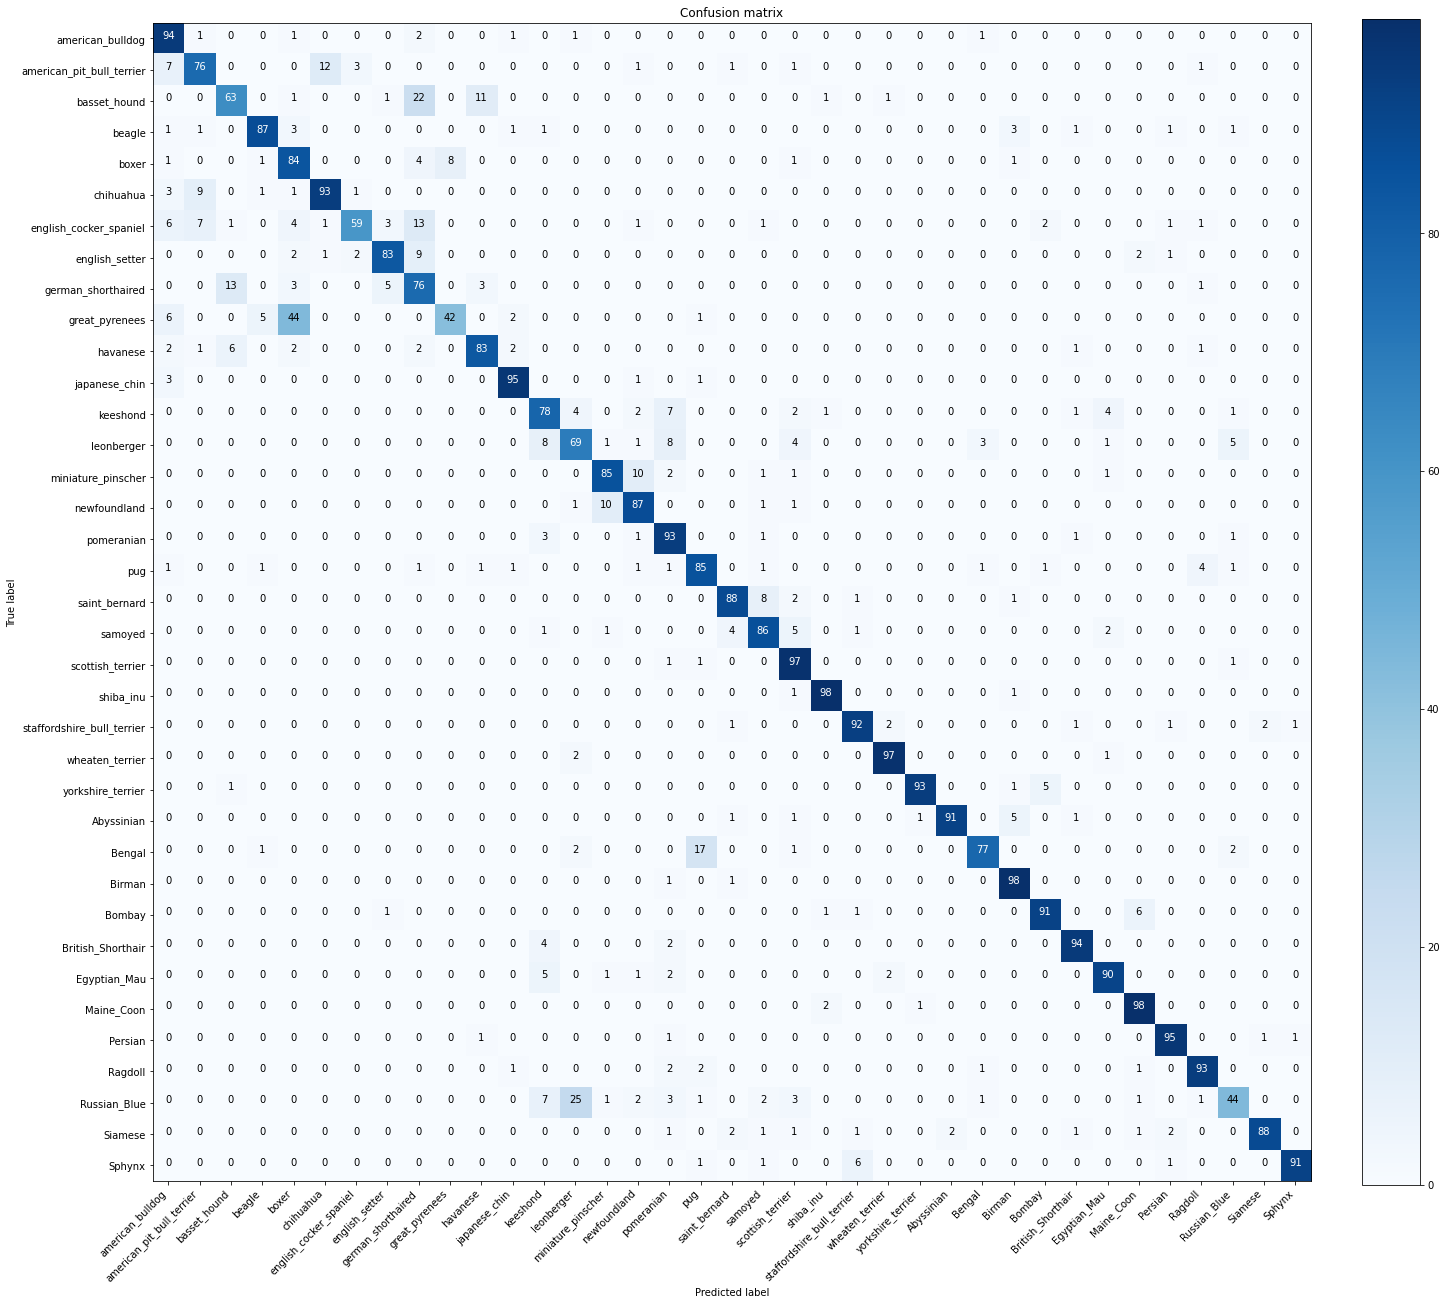

In [153]:
predict(cnnRes, testGen,classesNames,plot_matrix_color=True)

* O modelo  obteve uma accuracy de **0.84**.
* Este modelo obteve uma accuracy práticamente semelhante ao do modelo anterior, mesmo tendo um tamanho quase duas vezes superior.

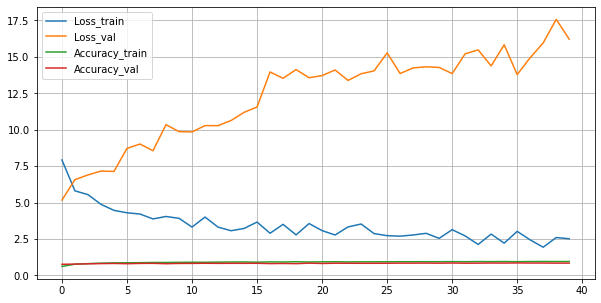

In [154]:
get_train_history(train)

A partir do modelo pode-se notar que a accuracy se encontra bastante semelhante para treino e validação, possivelmente devido à adição da camada de dropout final. Não se notou grande alteração a partir da EPOCH 15, e a loss no conjunto de validação começa a aumentar bastante, poderia ter sido utilizadas possivelmente menos EPOCHS.

In [155]:
cnnRes.save('models/modelMultiResnet101V2')

INFO:tensorflow:Assets written to: models/modelMultiResnet101V2\assets


<hr style="border:2px solid black"> </hr>

# Treino Binário

Realizou-se agora o processo de classificação binária.

Agora a classificação está dividada apenas entre gatos e cães.

Nesta etapa vão ser relatados os resultados obtidos com:
* Diferentes classificadores com e sem data augmentation.
* Diferentes redes pre-treinadas e redes já treinadas de raiz.
* Diferentes formas de pre-processamento dos dados mencionadas anteriormente.

### Diretoria com os dados binários

In [37]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

dbDir = "images_generation_bin/images_generation_bin"

## Treinar rede neuronal binária com data augmentation

* Utilizou-se uma rede neuronal com parâmetros semelhantes aos que já tinham sido utilizados anteriormente para a classificação multi-classe. Entretanto como este problema é mais simples em relação ao anterior, não foram usadas tantas unidades nas diferentes camadas.

* Para a camada de **output** utilizou-se duas unidades, entretanto a classificação poderia ter sido também realizada com apenas uma unidade. Porém como 2 unidades traduzem melhores resultados, escolheu-se este número.

In [84]:
modelBin = keras.Sequential()


modelBin.add(keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(ISize[0], ISize[0],3)))
modelBin.add(keras.layers.MaxPooling2D(pool_size=2))

modelBin.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same'))
modelBin.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
modelBin.add(keras.layers.MaxPooling2D(pool_size=2))

modelBin.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same'))
modelBin.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
modelBin.add(keras.layers.MaxPooling2D(pool_size=2))

modelBin.add(keras.layers.Dropout(0.05))
modelBin.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
modelBin.add(keras.layers.MaxPooling2D(pool_size=2))
modelBin.add(keras.layers.Dropout(0.1))
modelBin.add(keras.layers.Flatten())
modelBin.add(keras.layers.Dense(256, activation='relu'))


modelBin.add(keras.layers.Dense(2,activation='softmax'))

In [85]:
modelBin.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])

In [95]:
ePochs = 40
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = modelBin.fit(train_data,steps_per_epoch=speTrain,validation_data=test_data,validation_steps=speValid,epochs=ePochs)#, 
                   #callbacks=[callbacks])

Epoch 1/40
368/368 [==============================] - 37s 99ms/step - loss: 0.2629 - accuracy: 0.8876 - val_loss: 0.2780 - val_accuracy: 0.8795
Epoch 2/40
368/368 [==============================] - 38s 104ms/step - loss: 0.2540 - accuracy: 0.8904 - val_loss: 0.2875 - val_accuracy: 0.8684
Epoch 3/40
368/368 [==============================] - 38s 104ms/step - loss: 0.2641 - accuracy: 0.8898 - val_loss: 0.2687 - val_accuracy: 0.8832
Epoch 4/40
368/368 [==============================] - 37s 101ms/step - loss: 0.2572 - accuracy: 0.8876 - val_loss: 0.2938 - val_accuracy: 0.8689
Epoch 5/40
368/368 [==============================] - 37s 101ms/step - loss: 0.2662 - accuracy: 0.8882 - val_loss: 0.2857 - val_accuracy: 0.8773
Epoch 6/40
368/368 [==============================] - 37s 100ms/step - loss: 0.2597 - accuracy: 0.8852 - val_loss: 0.2658 - val_accuracy: 0.8832
Epoch 7/40
368/368 [==============================] - 37s 101ms/step - loss: 0.2596 - accuracy: 0.8912 - val_loss: 0.2485 - val_acc

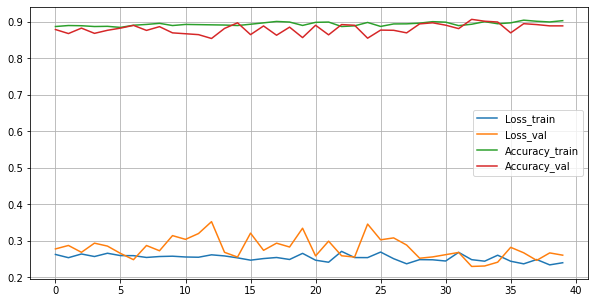

In [96]:
get_train_history(train)


A partir da accuracy de treino e teste pode-se observar valores muitos altos, ambos para o conjunto de treino e para o conjunto de teste.



A accuracy de treino e de teste têm valores semelhantes e a loss varia entre intervalos semelhantes, portanto o modelo não tem sinais de estar em sobre-aprendizagem.  

In [93]:
#len(test_data)
print(len(test_data.classes))

3704


In [97]:
predict(modelBin, test_data,classesNames,plot_matrix_color=False)

371/371 [==============================] - 5s 12ms/step
[[ 877  335]
 [  74 2418]]
409 erros em 3704 exemplos
%Accuracy: 88.95788336933046


* A partir do modelo binário com data augmentation foi obtido uma accuracy de teste de **0.89**, um bom valor.
* Será agora de seguida testada a classificação binária sem data augmentation.

In [ ]:
modelBin.save('models/modelBin')

<hr style="border:2px solid black"> </hr>

## Binário sem data augmentation

Vai ser agora testada a classificação binária sem o uso de técnicas de data augmentation.

O modelo vai ser igual ao anterior, de forma a conseguir averiguar se data augmentation é ou não benéfico para binário.

In [54]:
modelBin2 = keras.Sequential()


modelBin2.add(keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(ISize[0], ISize[0],3)))
#modelBin2.add(keras.layers.Normalization(mean=128,variance=128))

modelBin2.add(keras.layers.MaxPooling2D(pool_size=2))

modelBin2.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same'))
modelBin2.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
modelBin2.add(keras.layers.MaxPooling2D(pool_size=2))

modelBin2.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same'))
modelBin2.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
modelBin2.add(keras.layers.MaxPooling2D(pool_size=2))

modelBin2.add(keras.layers.Dropout(0.05))
modelBin2.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
modelBin2.add(keras.layers.MaxPooling2D(pool_size=2))
modelBin2.add(keras.layers.Dropout(0.1))
modelBin2.add(keras.layers.Flatten())
modelBin2.add(keras.layers.Dense(256, activation='relu'))


modelBin2.add(keras.layers.Dense(2,activation='softmax'))

In [55]:
modelBin2.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])

In [57]:
ePochs = 40
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = modelBin2.fit(train_data_without,steps_per_epoch=speTrain,validation_data=test_data,
                     validation_steps=speValid,epochs=ePochs)

Epoch 1/40
368/368 [==============================] - 38s 102ms/step - loss: 0.5874 - accuracy: 0.6956 - val_loss: 0.5464 - val_accuracy: 0.6997
Epoch 2/40
368/368 [==============================] - 38s 102ms/step - loss: 0.5804 - accuracy: 0.6902 - val_loss: 0.5674 - val_accuracy: 0.6803
Epoch 3/40
368/368 [==============================] - 38s 103ms/step - loss: 0.5712 - accuracy: 0.6986 - val_loss: 0.5448 - val_accuracy: 0.6900
Epoch 4/40
368/368 [==============================] - 38s 102ms/step - loss: 0.5581 - accuracy: 0.7103 - val_loss: 0.5210 - val_accuracy: 0.7351
Epoch 5/40
368/368 [==============================] - 38s 102ms/step - loss: 0.5540 - accuracy: 0.7092 - val_loss: 0.4886 - val_accuracy: 0.7608
Epoch 6/40
368/368 [==============================] - 38s 102ms/step - loss: 0.5378 - accuracy: 0.7239 - val_loss: 0.5306 - val_accuracy: 0.7305
Epoch 7/40
368/368 [==============================] - 37s 102ms/step - loss: 0.5257 - accuracy: 0.7345 - val_loss: 0.5241 - val_ac

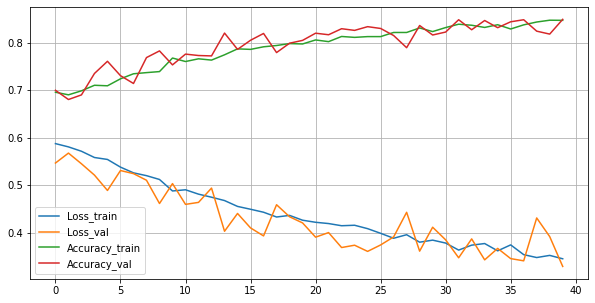

In [59]:
get_train_history(train)

A partir dos seguintes gráficos, pode-se observar que o modelo encontra-se muito menos estável que o anterior, tendo ambos para a accuracy e loss retas muito menos suaves, variando bastante entre EPOCHS.

Uma possível razão pode ser devido ao modelo vêr menos versões diferentes dos exemplos originais, e é exposto a menos aspectos dos dados, provocando uma diminuição da capacidade de generalizão e consistência do modelo em cada EPOCH.

In [64]:
predict(modelBin2, test_data,classesNames,plot_matrix_color=False)

371/371 [==============================] - 5s 13ms/step
[[ 818  394]
 [ 164 2328]]
558 erros em 3704 exemplos
%Accuracy: 84.93520518358531


* A partir do modelo binário **sem data augmentation** foi obtido uma accuracy de teste de **0.84**, um valor bastante inferior ao anterior.
* Conclui-se então que para o problema binário e multi-classe a utilização de data augmentation é positiva.
* Será agora de seguida testada a classificação binária com um modelo pré-treinado.

In [65]:
modelBin2.save('models/modelBinNoAug')

INFO:tensorflow:Assets written to: models/modelBinNoAug\assets


<hr style="border:2px solid black"> </hr>

## Modelo pré-treinado para classificação binária

De seguida vai ser testado um modelo pre-treinado para a classificação binária para verificar os resultados obtidos.

* O modelo utilizado irá ser o Xception devido a ser leve e ter obtido bons resultados para a classificação multi-classe.

In [44]:
from keras.applications.xception import Xception

cnnBase = Xception(weights="imagenet",include_top=False, input_shape=(ISize[0], ISize[1],3))
cnnBase.trainable=False

cnnBin3=keras.models.Sequential()
cnnBin3.add(cnnBase)
cnnBin3.add(keras.layers.MaxPooling2D((2, 2)))
cnnBin3.add(keras.layers.Flatten())
cnnBin3.add(keras.layers.Dropout(.3))
cnnBin3.add(keras.layers.Dense(2, activation="softmax"))


In [45]:
cnnBin3.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])

In [46]:
ePochs = 40
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = cnnBin3.fit(train_data,steps_per_epoch=speTrain,validation_data=test_data,validation_steps=speValid,epochs=ePochs)

Epoch 1/40
368/368 [==============================] - 61s 141ms/step - loss: 0.2751 - accuracy: 0.9467 - val_loss: 0.1583 - val_accuracy: 0.9846
Epoch 2/40
368/368 [==============================] - 49s 132ms/step - loss: 0.2653 - accuracy: 0.9674 - val_loss: 0.2087 - val_accuracy: 0.9814
Epoch 3/40
368/368 [==============================] - 48s 131ms/step - loss: 0.2518 - accuracy: 0.9723 - val_loss: 0.2168 - val_accuracy: 0.9849
Epoch 4/40
368/368 [==============================] - 50s 135ms/step - loss: 0.2622 - accuracy: 0.9728 - val_loss: 0.3284 - val_accuracy: 0.9805
Epoch 5/40
368/368 [==============================] - 49s 132ms/step - loss: 0.2776 - accuracy: 0.9771 - val_loss: 0.2208 - val_accuracy: 0.9865
Epoch 6/40
368/368 [==============================] - 49s 132ms/step - loss: 0.2888 - accuracy: 0.9755 - val_loss: 0.2404 - val_accuracy: 0.9824
Epoch 7/40
368/368 [==============================] - 49s 132ms/step - loss: 0.2684 - accuracy: 0.9796 - val_loss: 0.3064 - val_ac

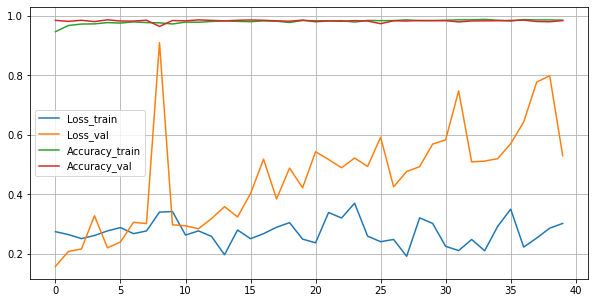

In [47]:
get_train_history(train)

É possivel notar que o modelo manteve-se bastante estavél a partir da EPOCH 10 em relação à accuracy, tendo aumentado gradualmente.

É possivel também notar alguma instabilidade entre diferentes EPOCHS para o valor da loss.

Em geral, os resultados obtidos por este classificador para ambas as accuracys foi perto de 100 porcento.

In [48]:
predict(cnnBin3, test_data,classesNames,plot_matrix_color=False)

371/371 [==============================] - 17s 44ms/step
[[1187   25]
 [  35 2457]]
60 erros em 3704 exemplos
%Accuracy: 98.38012958963283


* A partir do modelo foi obtido uma accuracy de teste de **0.98**, um valor bastante superior ao anterior.
* Valores tão elevados eram esperáveis devido à facilidade do problema de classificação utilizando um modelo pre-treinado.

In [49]:
cnnBin3.save('models/modelBinCNN')

INFO:tensorflow:Assets written to: models/modelBinCNN\assets


<hr style="border:2px solid black"> </hr>

# Treino do modelo com o conjunto de dados sem padding

Anteriormente foram abordados os resultados obtidos para os dados com padding.

Agora vão ser analisados os resultados obtidos **sem a utilização do padding**.

## Treino Multi-classe

Primeiro vai ser analisado o desempenho do modelo sem padding para classificação multi-classe.

* Irá ser utilizado um modelo igual ao utilizado para os dados com padding.

In [60]:
modelNoPad = keras.Sequential()
modelNoPad.add(keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(ISize[0], ISize[0],3)))
modelNoPad.add(keras.layers.MaxPooling2D(pool_size=2))

modelNoPad.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
modelNoPad.add(keras.layers.MaxPooling2D(pool_size=2))
modelNoPad.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
modelNoPad.add(keras.layers.MaxPooling2D(pool_size=2))
modelNoPad.add(keras.layers.Dropout(0.2))
modelNoPad.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
modelNoPad.add(keras.layers.MaxPooling2D(pool_size=2))
modelNoPad.add(keras.layers.Dropout(0.2))
modelNoPad.add(keras.layers.Flatten())


modelNoPad.add(keras.layers.Dense(512, activation='relu'))
modelNoPad.add(keras.layers.Dense(37,activation='softmax'))

In [61]:
modelNoPad.compile(optimizer="nadam", loss="categorical_crossentropy",metrics=["accuracy"])

In [62]:
ePochs = 60
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = modelNoPad.fit(get_train_data(base_folder_multi_no_padding),steps_per_epoch=speTrain,
                   validation_data=get_test_data(base_folder_multi_no_padding), validation_steps=speValid,epochs=ePochs)

Found 3686 images belonging to 37 classes.
Found 3704 images belonging to 37 classes.
Epoch 1/60
368/368 [==============================] - 46s 116ms/step - loss: 3.6092 - accuracy: 0.0335 - val_loss: 3.5160 - val_accuracy: 0.0592
Epoch 2/60
368/368 [==============================] - 44s 115ms/step - loss: 3.4875 - accuracy: 0.0642 - val_loss: 3.3995 - val_accuracy: 0.0805
Epoch 3/60
368/368 [==============================] - 44s 115ms/step - loss: 3.3754 - accuracy: 0.0827 - val_loss: 3.2803 - val_accuracy: 0.1065
Epoch 4/60
368/368 [==============================] - 44s 115ms/step - loss: 3.2524 - accuracy: 0.1072 - val_loss: 3.1751 - val_accuracy: 0.1241
Epoch 5/60
368/368 [==============================] - 44s 115ms/step - loss: 3.1325 - accuracy: 0.1306 - val_loss: 3.0637 - val_accuracy: 0.1514
Epoch 6/60
368/368 [==============================] - 44s 115ms/step - loss: 3.0586 - accuracy: 0.1572 - val_loss: 3.0084 - val_accuracy: 0.1608
Epoch 7/60
368/368 [========================

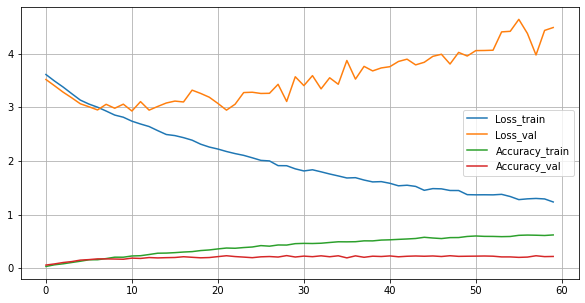

In [63]:
get_train_history(train)

A partir do gráfico da história do treino é possível observar que como no caso do modelo com padding, o modelo está a entrar em sobre-aprendizagem. A história do treino tem um aspeto semelhante ao modelo com padding.

Found 3704 images belonging to 37 classes.
371/371 [==============================] - 7s 15ms/step
[[25  7  0 ...  0  6  3]
 [ 5 39  0 ...  3  2  3]
 [ 1  0 29 ...  0  1  2]
 ...
 [ 1  1  0 ... 11  1  1]
 [ 5  2  1 ...  0 15  4]
 [ 5 12  1 ...  2  5  7]]
Confusion matrix, without normalization
2890 erros em 3704 exemplos
%Accuracy: 21.97624190064795


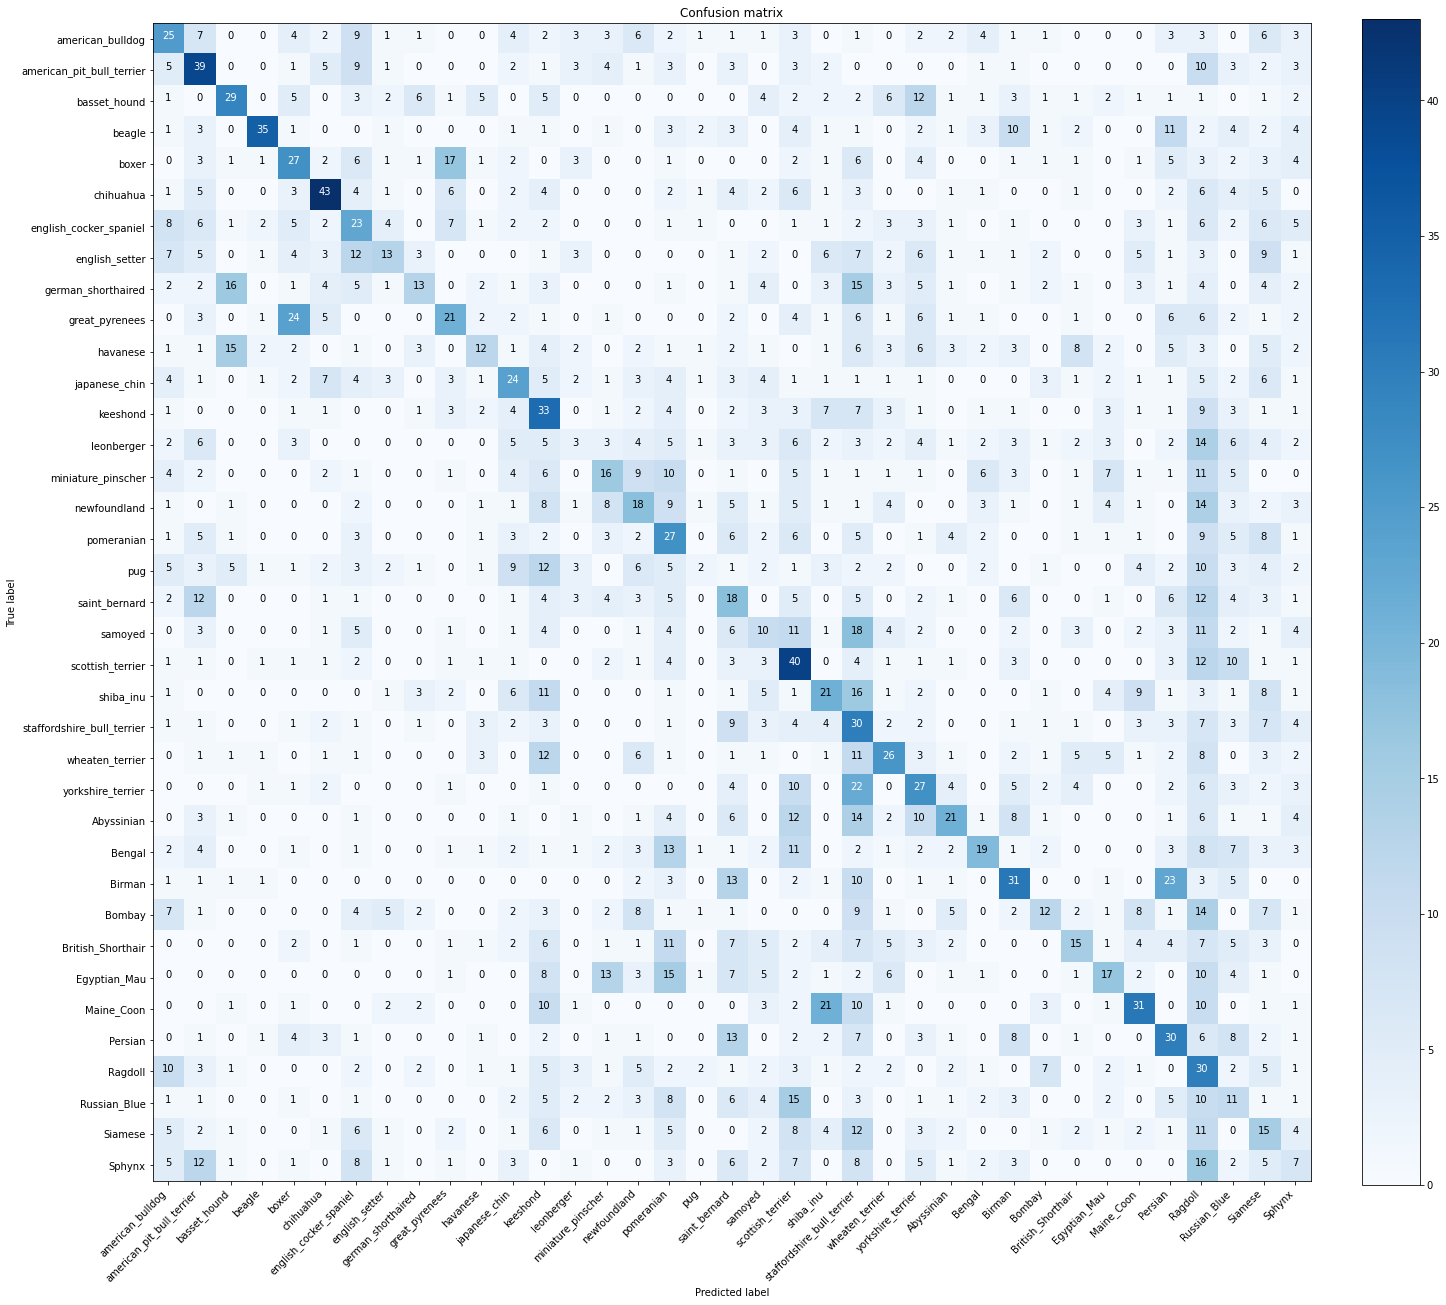

In [65]:
predict(modelNoPad, get_test_data(base_folder_multi_no_padding),classesNames,plot_matrix_color=True)

* Obteu-se para a rede neuronal sem padding uma accuracy de **0.22**.
* Para a mesma rede neuronal treinada de raiz com padding obteu-se uma accuracy de **0.23**.
* Os resultados obtidos são parecidos, tendo a utilização de padding uma vantagem ligeira.

### Treinar rede neuronal com modelo pre treinado do Keras sem padding

Irá agora ser testado como os dados sem padding se enquadram com o modelo pré-treinado.

O modelo pré-treinado do Keras utilizado vai ser o Xception, que também foi utilizado anteriormente.

In [85]:
from keras.applications.xception import Xception

cnnBase = Xception(weights="imagenet",include_top=False, input_shape=(ISize[0], ISize[1],3))
cnnBase.trainable=False

cnnNoPad=keras.models.Sequential()
cnnNoPad.add(cnnBase)
cnnNoPad.add(keras.layers.MaxPooling2D((2, 2)))
cnnNoPad.add(keras.layers.Flatten())
cnnNoPad.add(keras.layers.Dropout(.3))
cnnNoPad.add(keras.layers.Dense(37, activation="softmax"))

cnnNoPad.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])

In [87]:
ePochs=40
speTrain=3686 //bSize
speValid=3704 //bSize
train = cnnNoPad.fit(get_train_data(base_folder_multi_no_padding),steps_per_epoch=speTrain,
                   validation_data=get_test_data(base_folder_multi_no_padding), validation_steps=speValid,epochs=ePochs)

Found 3686 images belonging to 37 classes.
Found 3704 images belonging to 37 classes.
Epoch 1/40
368/368 [==============================] - 61s 152ms/step - loss: 2.4403 - accuracy: 0.6961 - val_loss: 1.8555 - val_accuracy: 0.8105
Epoch 2/40
368/368 [==============================] - 55s 145ms/step - loss: 2.0530 - accuracy: 0.7930 - val_loss: 1.7093 - val_accuracy: 0.8419
Epoch 3/40
368/368 [==============================] - 55s 144ms/step - loss: 1.9457 - accuracy: 0.8275 - val_loss: 1.8066 - val_accuracy: 0.8543
Epoch 4/40
368/368 [==============================] - 55s 145ms/step - loss: 1.8902 - accuracy: 0.8406 - val_loss: 2.0912 - val_accuracy: 0.8392
Epoch 5/40
368/368 [==============================] - 55s 145ms/step - loss: 1.6855 - accuracy: 0.8493 - val_loss: 2.5136 - val_accuracy: 0.8286
Epoch 6/40
368/368 [==============================] - 55s 145ms/step - loss: 1.6075 - accuracy: 0.8621 - val_loss: 2.3258 - val_accuracy: 0.8516
Epoch 7/40
368/368 [========================

Found 3704 images belonging to 37 classes.
371/371 [==============================] - 17s 40ms/step
[[87  2  0 ...  0  0  0]
 [ 3 77  0 ...  0  0  0]
 [ 0  0 70 ...  0  0  0]
 ...
 [ 0  0  0 ... 68  0  0]
 [ 0  0  0 ...  2 93  0]
 [ 0  0  0 ...  0  0 98]]
Confusion matrix, without normalization
443 erros em 3704 exemplos
%Accuracy: 88.03995680345572


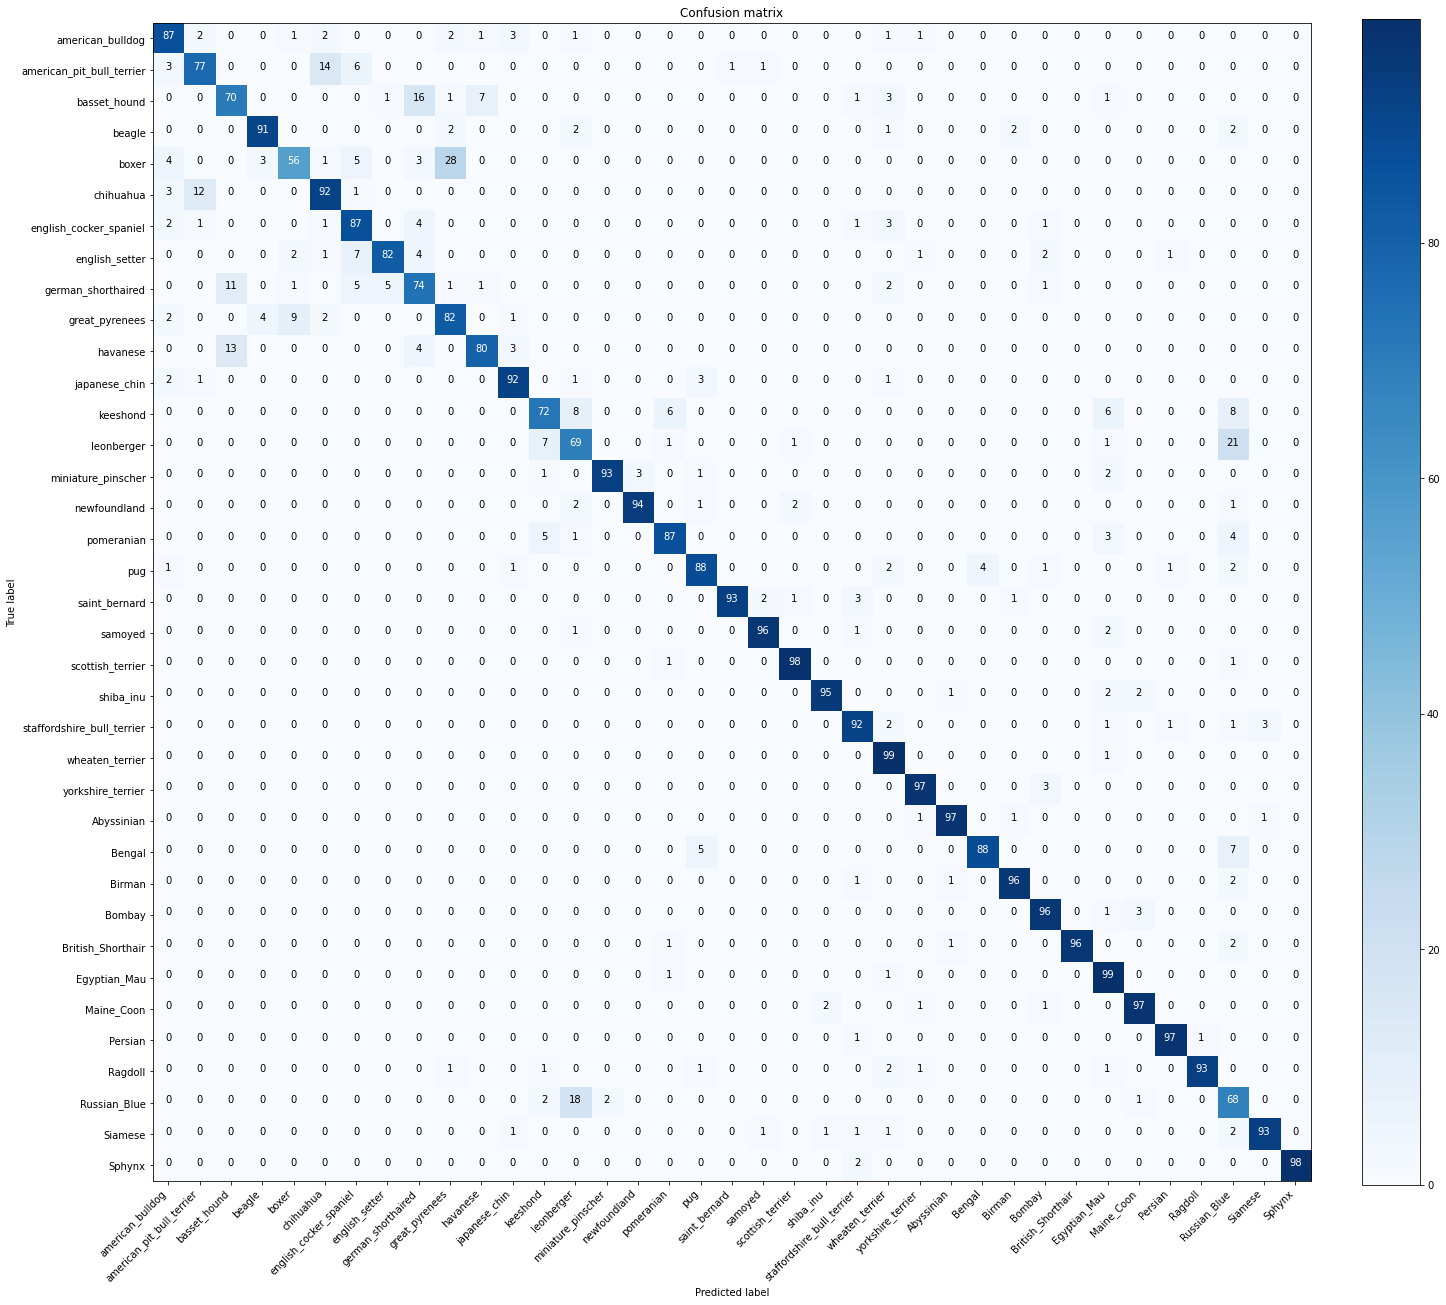

In [90]:
predict(cnnNoPad, get_test_data(base_folder_multi_no_padding),classesNames,plot_matrix_color=True)

* No modelo pre-treinado foi obtidos melhores resultados com o conjunto de dados sem padding, tendo sido obtido uma accuracy de **0.88**.
* No modelo pre-treinado com padding foi apenas obtida uma accuracy de **0.84**.

O modelo pre-treinado teve um melhor desempenho sem padding, sendo preferível com o modelo pré-treinado ter algum nivel de distorção nas imagens devido a alongamento do que uma barra preta de padding.

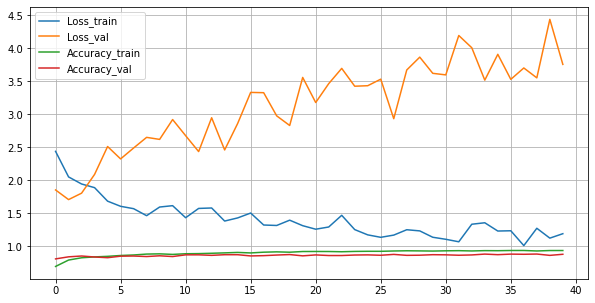

In [89]:
get_train_history(train)

Como se pode observar pela evolução do treino, ambos os valores de accuracy são muito semelhantes e foram aumentado ao longo das diferentes EPOCHS com a loss de treino em tendência de dimuninição e a loss de validação a aumentar.

<hr style="border:2px solid black"> </hr>

## Classificação binária sem padding

Finalmente vai ser testado o desempenho do conjunto de dados sem padding no problema de classificação binária.

In [66]:
modelBinNoPad = keras.Sequential()


modelBinNoPad.add(keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(ISize[0], ISize[0],3)))
modelBinNoPad.add(keras.layers.MaxPooling2D(pool_size=2))

modelBinNoPad.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same'))
modelBinNoPad.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
modelBinNoPad.add(keras.layers.MaxPooling2D(pool_size=2))

modelBinNoPad.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same'))
modelBinNoPad.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
modelBinNoPad.add(keras.layers.MaxPooling2D(pool_size=2))

modelBinNoPad.add(keras.layers.Dropout(0.05))
modelBinNoPad.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
modelBinNoPad.add(keras.layers.MaxPooling2D(pool_size=2))
modelBinNoPad.add(keras.layers.Dropout(0.1))
modelBinNoPad.add(keras.layers.Flatten())
modelBinNoPad.add(keras.layers.Dense(256, activation='relu'))


modelBinNoPad.add(keras.layers.Dense(2,activation='softmax'))

In [67]:
modelBinNoPad.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])

In [68]:
ePochs = 40
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = modelBinNoPad.fit(get_train_data(base_folder_bin_no_padding),steps_per_epoch=speTrain,
                          validation_data=get_test_data(base_folder_bin_no_padding),validation_steps=speValid,epochs=ePochs)

Found 3686 images belonging to 2 classes.
Found 3704 images belonging to 2 classes.
Epoch 1/40
368/368 [==============================] - 52s 130ms/step - loss: 0.6433 - accuracy: 0.6766 - val_loss: 0.5586 - val_accuracy: 0.6749
Epoch 2/40
368/368 [==============================] - 47s 122ms/step - loss: 0.5987 - accuracy: 0.6776 - val_loss: 0.5467 - val_accuracy: 0.6816
Epoch 3/40
368/368 [==============================] - 46s 121ms/step - loss: 0.5876 - accuracy: 0.6945 - val_loss: 0.5553 - val_accuracy: 0.7059
Epoch 4/40
368/368 [==============================] - 47s 122ms/step - loss: 0.5763 - accuracy: 0.7027 - val_loss: 0.5360 - val_accuracy: 0.7000
Epoch 5/40
368/368 [==============================] - 46s 121ms/step - loss: 0.5671 - accuracy: 0.7043 - val_loss: 0.5547 - val_accuracy: 0.7070
Epoch 6/40
368/368 [==============================] - 46s 121ms/step - loss: 0.5632 - accuracy: 0.7081 - val_loss: 0.4999 - val_accuracy: 0.7724
Epoch 7/40
368/368 [==========================

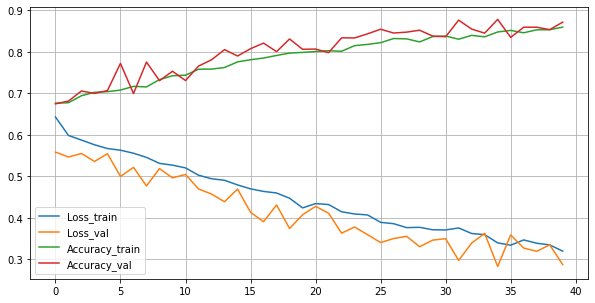

In [69]:
get_train_history(train)

In [71]:
predict(modelBinNoPad, get_test_data(base_folder_bin_no_padding),classesNames,plot_matrix_color=False)

Found 3704 images belonging to 2 classes.
371/371 [==============================] - 8s 14ms/step
[[ 878  334]
 [ 141 2351]]
475 erros em 3704 exemplos
%Accuracy: 87.17602591792657


* A accuracy obtida para classificação binária sem padding foi **0.87**.
* A accuracy obtida para a classificação binária com padding foi perto **0.89**.

Para o problema de classificação binária o conjunto de dados com padding teve melhores resultados.

<hr style="border:2px solid black"> </hr>

# Treino do modelo com o conjunto de dados com bounding box

Por fim o último conjunto de dados testado é o conjunto de dados em que as imagens de treino têm só a bounding box da cara dos animais.

Como existe uma grande discrepância entre o conjunto de treino e de teste, este conjunto de dados é esperado ter piores resultados.

### Treino multi-classe com bounding box

Inicialmente treinou-se o classificador multi-classe de forma igual à anterior.

In [73]:
modelBbx = keras.Sequential()
modelBbx.add(keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(ISize[0], ISize[0],3)))
modelBbx.add(keras.layers.MaxPooling2D(pool_size=2))

modelBbx.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
modelBbx.add(keras.layers.MaxPooling2D(pool_size=2))
modelBbx.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
modelBbx.add(keras.layers.MaxPooling2D(pool_size=2))
modelBbx.add(keras.layers.Dropout(0.2))
modelBbx.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
modelBbx.add(keras.layers.MaxPooling2D(pool_size=2))
modelBbx.add(keras.layers.Dropout(0.2))
modelBbx.add(keras.layers.Flatten())


modelBbx.add(keras.layers.Dense(512, activation='relu'))
modelBbx.add(keras.layers.Dense(37,activation='softmax'))

In [74]:
modelBbx.compile(optimizer="nadam", loss="categorical_crossentropy",metrics=["accuracy"])

In [75]:
ePochs = 40
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = modelBbx.fit(get_train_data(base_folder_multi_bbx),steps_per_epoch=speTrain,
                   validation_data=get_test_data(base_folder_multi_bbx), validation_steps=speValid,epochs=ePochs)

Found 3686 images belonging to 37 classes.
Found 3704 images belonging to 37 classes.
Epoch 1/40
368/368 [==============================] - 49s 124ms/step - loss: 3.4605 - accuracy: 0.0699 - val_loss: 3.8022 - val_accuracy: 0.0416
Epoch 2/40
368/368 [==============================] - 45s 116ms/step - loss: 3.0581 - accuracy: 0.1483 - val_loss: 4.0631 - val_accuracy: 0.0559
Epoch 3/40
368/368 [==============================] - 44s 115ms/step - loss: 2.8564 - accuracy: 0.2002 - val_loss: 3.9224 - val_accuracy: 0.0632
Epoch 4/40
368/368 [==============================] - 44s 115ms/step - loss: 2.6724 - accuracy: 0.2353 - val_loss: 4.2056 - val_accuracy: 0.0730
Epoch 5/40
368/368 [==============================] - 44s 115ms/step - loss: 2.5427 - accuracy: 0.2816 - val_loss: 4.1385 - val_accuracy: 0.0762
Epoch 6/40
368/368 [==============================] - 44s 115ms/step - loss: 2.4249 - accuracy: 0.3039 - val_loss: 4.2584 - val_accuracy: 0.0743
Epoch 7/40
368/368 [========================

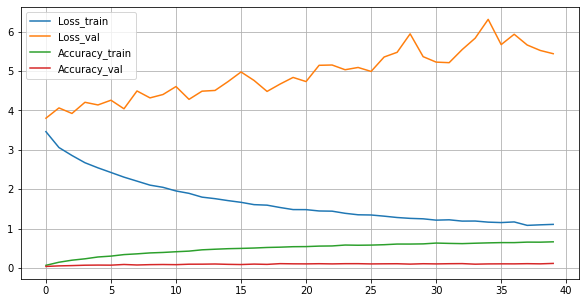

In [76]:
get_train_history(train)

Como se pode observar, o modelo obteve resultados muito inferiores aos obtidos para os dados com padding e sem padding.

A utilização do padding não está a ser benéfica de maneira alguma.

In [ ]:
predict(modelBbx, get_test_data(base_folder_multi_bbx),classesNames,plot_matrix_color=True)

## Treino multi-classe com modelo pre-treinado do Keras com bounding box

De seguida foi testado o desempenho do modelo com o modelo Xcecption.

In [91]:
from keras.applications.xception import Xception

cnnBase = Xception(weights="imagenet",include_top=False, input_shape=(ISize[0], ISize[1],3))
cnnBase.trainable=False

cnnBbx=keras.models.Sequential()
cnnBbx.add(cnnBase)
cnnBbx.add(keras.layers.MaxPooling2D((2, 2)))
cnnBbx.add(keras.layers.Flatten())
cnnBbx.add(keras.layers.Dropout(.3))
cnnBbx.add(keras.layers.Dense(37, activation="softmax"))

cnnBbx.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])

In [92]:
ePochs=40
speTrain=3686 //bSize
speValid=3704 //bSize
train = cnnBbx.fit(get_train_data(base_folder_multi_bbx),steps_per_epoch=speTrain,
                   validation_data=get_test_data(base_folder_multi_bbx), validation_steps=speValid,epochs=ePochs)

Found 3686 images belonging to 37 classes.
Found 3704 images belonging to 37 classes.
Epoch 1/40
368/368 [==============================] - 60s 149ms/step - loss: 1.6198 - accuracy: 0.7508 - val_loss: 2.0484 - val_accuracy: 0.7851
Epoch 2/40
368/368 [==============================] - 55s 145ms/step - loss: 1.3478 - accuracy: 0.8338 - val_loss: 3.5905 - val_accuracy: 0.7262
Epoch 3/40
368/368 [==============================] - 57s 149ms/step - loss: 1.1367 - accuracy: 0.8700 - val_loss: 3.1750 - val_accuracy: 0.7727
Epoch 4/40
368/368 [==============================] - 55s 144ms/step - loss: 1.1763 - accuracy: 0.8800 - val_loss: 4.1199 - val_accuracy: 0.7527
Epoch 5/40
368/368 [==============================] - 55s 146ms/step - loss: 1.0931 - accuracy: 0.9002 - val_loss: 4.2813 - val_accuracy: 0.7673
Epoch 6/40
368/368 [==============================] - 55s 144ms/step - loss: 1.0990 - accuracy: 0.8906 - val_loss: 4.6286 - val_accuracy: 0.7627
Epoch 7/40
368/368 [========================

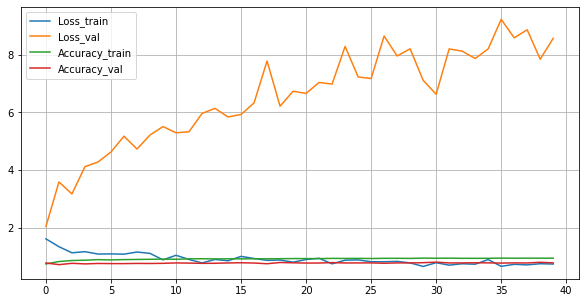

In [93]:
get_train_history(train)

Found 3704 images belonging to 37 classes.
371/371 [==============================] - 17s 40ms/step
[[67  3  0 ...  0  0  0]
 [ 9 37  0 ...  0  0  0]
 [ 1  0 66 ...  0  0  0]
 ...
 [ 0  0  0 ... 58  0  0]
 [ 0  0  0 ...  0 86  1]
 [ 0  0  0 ...  0  0 98]]
Confusion matrix, without normalization
784 erros em 3704 exemplos
%Accuracy: 78.83369330453564


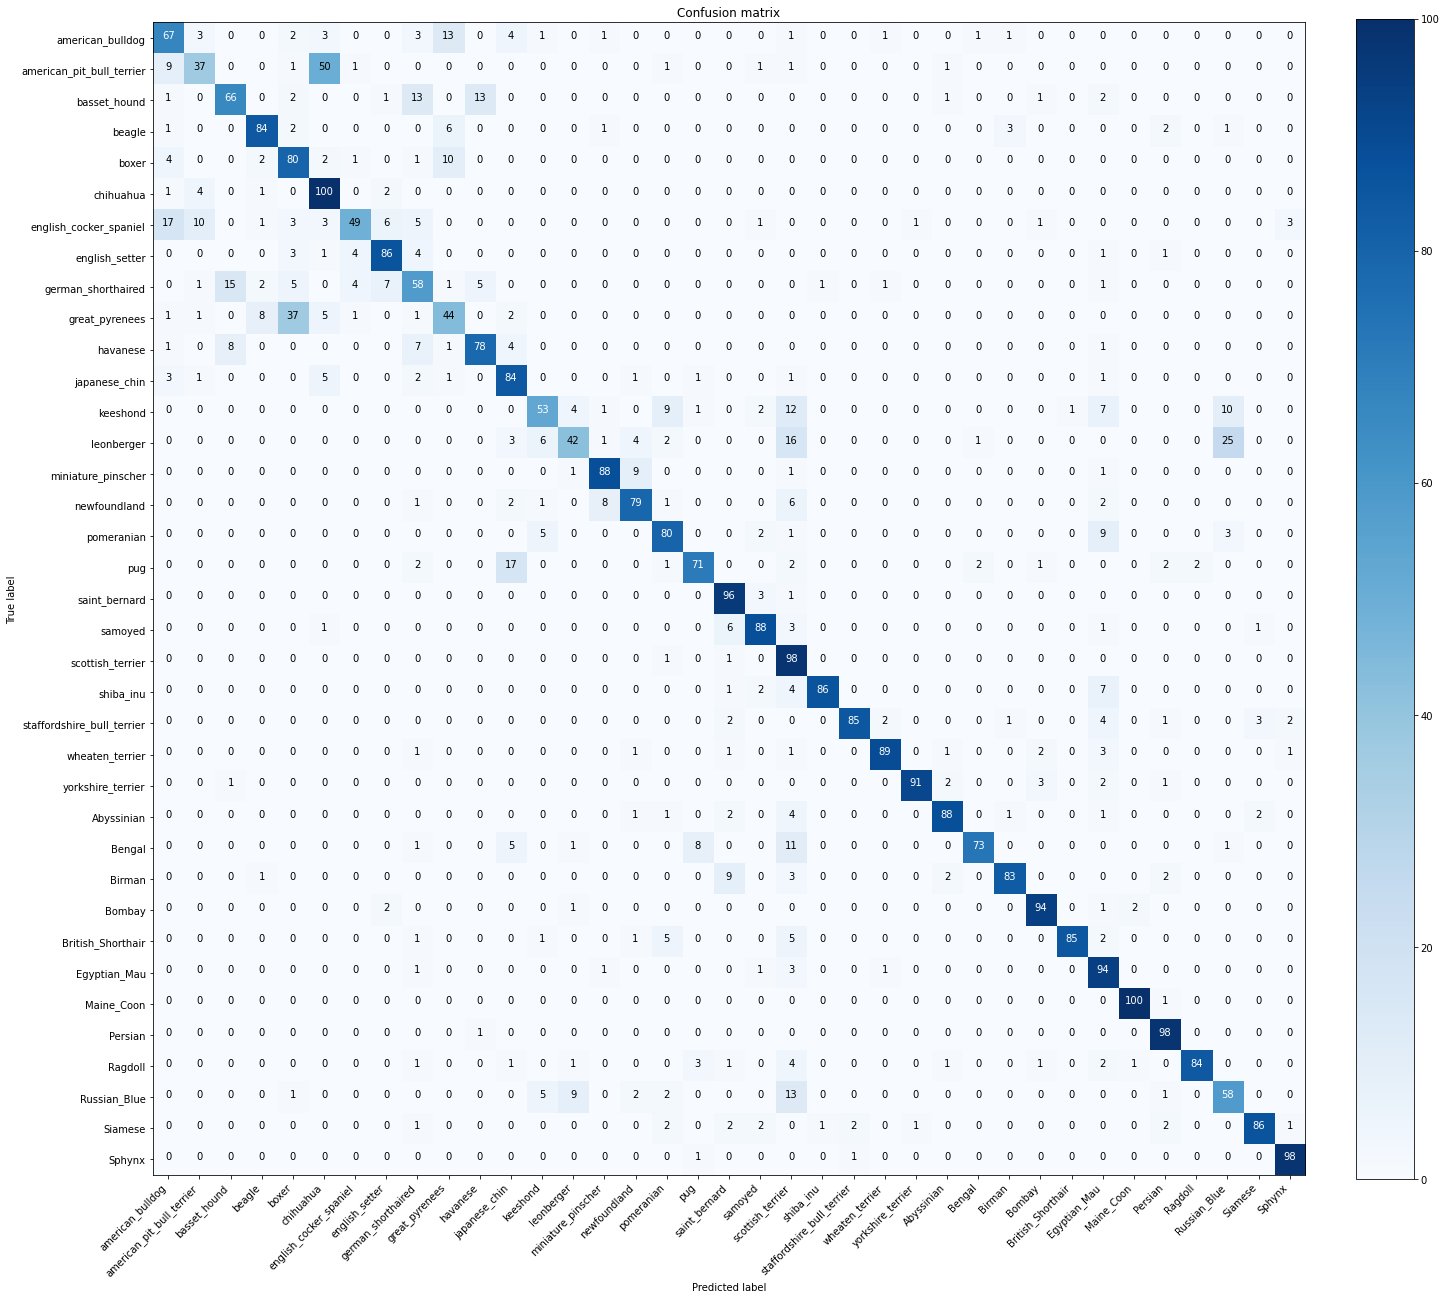

In [94]:
predict(cnnBbx, get_test_data(base_folder_multi_bbx),classesNames,plot_matrix_color=True)

* Neste modelo foi obtido uma accuracy de **0.78**.
* A accuracy neste modelo é muito inferior ao dos modelos anteriores sem padding e com padding.

Para o processo de classificação multi-classe a utilização da bounding box no conjunto de treino não trouxe algum benificio.

<hr style="border:2px solid black"> </hr>

## Treino binário com bounding box

Finalmente testou-se também o desempenho do modelo binário com a bounding box.

In [78]:
modelBinBbx = keras.Sequential()


modelBinBbx.add(keras.layers.Conv2D(filters=16, kernel_size=2, padding='same', activation='relu', input_shape=(ISize[0], ISize[0],3)))
modelBinBbx.add(keras.layers.MaxPooling2D(pool_size=2))

modelBinBbx.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same'))
modelBinBbx.add(keras.layers.Conv2D(filters=32, kernel_size=2 , padding='same' , activation='relu'))
modelBinBbx.add(keras.layers.MaxPooling2D(pool_size=2))

modelBinBbx.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same'))
modelBinBbx.add(keras.layers.Conv2D(filters=64 , kernel_size=2 , padding='same' , activation='relu'))
modelBinBbx.add(keras.layers.MaxPooling2D(pool_size=2))

modelBinBbx.add(keras.layers.Dropout(0.05))
modelBinBbx.add(keras.layers.Conv2D(filters=128 , kernel_size=2 , padding='same' , activation='relu'))
modelBinBbx.add(keras.layers.MaxPooling2D(pool_size=2))
modelBinBbx.add(keras.layers.Dropout(0.1))
modelBinBbx.add(keras.layers.Flatten())
modelBinBbx.add(keras.layers.Dense(256, activation='relu'))


modelBinBbx.add(keras.layers.Dense(2,activation='softmax'))

In [79]:
modelBinBbx.compile(optimizer="nadam",loss="categorical_crossentropy",metrics=["accuracy"])

In [80]:
ePochs = 40
speTrain = 3686 //bSize
speValid = 3704 //bSize
train = modelBinBbx.fit(get_train_data(base_folder_bin_bbx),steps_per_epoch=speTrain,
                          validation_data=get_test_data(base_folder_bin_bbx),validation_steps=speValid,epochs=ePochs)

Found 3686 images belonging to 2 classes.
Found 3704 images belonging to 2 classes.
Epoch 1/40
368/368 [==============================] - 49s 123ms/step - loss: 0.6183 - accuracy: 0.6768 - val_loss: 0.6680 - val_accuracy: 0.6630
Epoch 2/40
368/368 [==============================] - 43s 113ms/step - loss: 0.5976 - accuracy: 0.6768 - val_loss: 0.6535 - val_accuracy: 0.6514
Epoch 3/40
368/368 [==============================] - 44s 114ms/step - loss: 0.5421 - accuracy: 0.7165 - val_loss: 0.7548 - val_accuracy: 0.6803
Epoch 4/40
368/368 [==============================] - 43s 113ms/step - loss: 0.4523 - accuracy: 0.7875 - val_loss: 0.6934 - val_accuracy: 0.6435
Epoch 5/40
368/368 [==============================] - 44s 115ms/step - loss: 0.4065 - accuracy: 0.8085 - val_loss: 0.7149 - val_accuracy: 0.6449
Epoch 6/40
368/368 [==============================] - 43s 113ms/step - loss: 0.3828 - accuracy: 0.8324 - val_loss: 0.8492 - val_accuracy: 0.6132
Epoch 7/40
368/368 [==========================

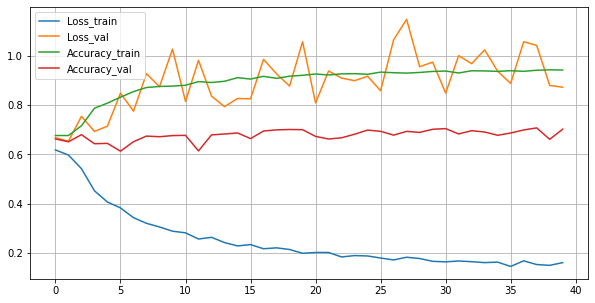

In [81]:
get_train_history(train)

In [83]:
predict(modelBinBbx, get_test_data(base_folder_bin_bbx),classesNames,plot_matrix_color=False)

Found 3704 images belonging to 2 classes.
371/371 [==============================] - 8s 15ms/step
[[ 230  982]
 [ 118 2374]]
1100 erros em 3704 exemplos
%Accuracy: 70.3023758099352


Para o processo binário foi apenas obtida uma accuracy de **0.70**, um valor muito inferior aos obtidos nos outros conjuntos de dados.

A partir dos resultados obtidos pode-se determinar que a adição da bounding box ao conjunto de treino não trouxe nenhum beníficio.

<hr style="border:2px solid black"> </hr>

# Resultados Obtidos

Na seguinte tabela podem ser observados os resultados obtidos para os diferentes conjuntos de dados, nos diferentes tipos de problemas de classificação com data augmentation:

  | | Class. Multiclasse de raiz | Class. Multiclasse c/ modelo Xception | Class. Binária | 
|---:|:-------------|:-----------|:------|
| **Dados com padding s/ bbox** | 0.23 | 0.84 | 0.89 | 
| **Dados sem padding s/ bbox** | 0.22 | 0.88 | 0.87 | 
| **Dados com padding c/ bbox** | 0.11 | 0.78 | 0.70 | 



A partir da tabela é possivél tomar as seguintes conclusões:

* O desempenho do conjunto de dados com padding e sem padding, foi muito semelhante. O lado positivo da utilização de padding é a não distorção das imagens originais, entretanto como as imagens de teste não têm padding as imagens de treino com padding ficam a diferir bastante das originais. Por estas razões os resultados obtidos foram semelhantes.

* A utilização da bounding box não foi benéfica, devido à grande discrepância entre os dados do conjunto de treino e de teste.

<hr style="border:1px solid black"> </hr>

### Data Augmentation

Na seguinte tabela, pode-se observar os resultados obtidos para a classificação multi-classe e binária com e sem data augmentation.

  | | Class. Multiclasse | Class. Binária | 
|---:|:-------------|:-----------
| **Dados com padding c/ data Aug.** | 0.19 | 0.15 
| **Dados com padding s/ data Aug.** | 0.89 | 0.85 


Foi de notar também que a **utilização de data augmenation** foi positiva para os resultados obtidos. Estas técnincas permitem o modelo vêr muitas versões diferentes dos exemplos originais, sendo exposto a mais aspectos dos dados, ajudando à generalização do modelo.

<hr style="border:1px solid black"> </hr>

### Modelos pré-treinados do Keras

A utilização de modelos pré-treinado quer seja Xcpetion e ResNet permitiram a obtenção de resultados muito superiores do que os resultados obtidos para os modelos treinados de raiz, como seria de esperar. A utilização destes modelos pre-treinados é uma boa forma de obter bons resultados mesmo não tendo o maior número possível de dados disponíveis para treino.

<hr style="border:1px solid black"> </hr>

### Pré-processamento dos dados

A conversão das imagens para o formato (224, 224) ofereceu bons resultados e teve a vantagem de ser a input shape utilizada por omissão nos modelos pre-treinados do Keras utilizados.